In [1]:
# All comments in English
import sys, os, pathlib
print("PY:", sys.executable)  # deve ser .../projects/slicing/venv/bin/python
print("CWD:", os.getcwd())
print("Has utils here?:", (pathlib.Path.cwd()/"utils").exists())


PY: /home/cecilia/5g-slicing-energy-effiiciency/venv/bin/python
CWD: /home/cecilia/5g-slicing-energy-effiiciency/simulator
Has utils here?: True


In [2]:
import sys
print(sys.executable)


/home/cecilia/5g-slicing-energy-effiiciency/venv/bin/python


In [4]:
from utils.create_folder import create_simulation_folder

In [5]:
results_dir = create_simulation_folder()


[INFO] Simulation folder created: results/2025-12-01_10-24-17


# Corridor restrictions

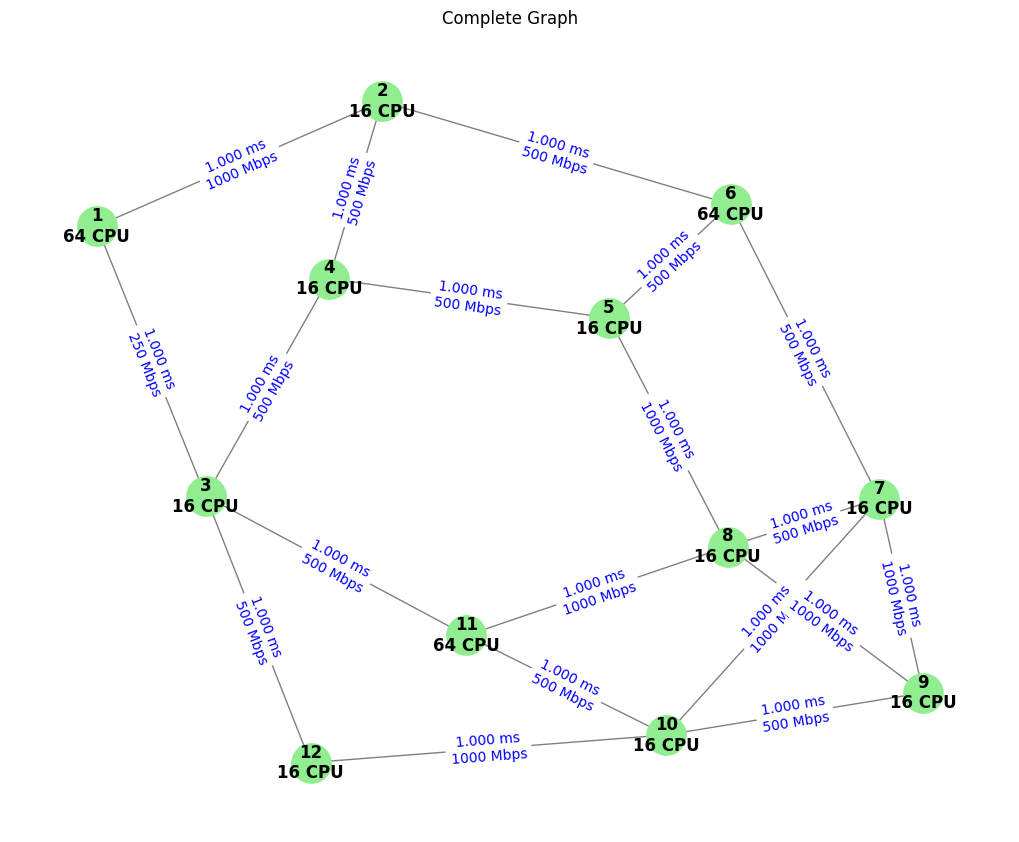

In [6]:
from utils.topology import topology_bayern, draw_graph, topologie_finlande, topology_brazil
from utils.generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()

draw_graph(G)


In [7]:

from utils.generate_slices import generate_random_slices


# === Define corridor in the topology ===
vnf_profiles = [
    {"cpu": 2, "throughput": 40, "latency": 120},
    {"cpu": 4, "throughput": 50, "latency": 180},
    {"cpu": 6, "throughput": 60, "latency": 200},
    {"cpu": 8, "throughput": 75, "latency": 250}
]

slices = generate_random_slices(G, vnf_profiles, num_slices=20, num_vnfs_per_slice=3, entry = 6)
slices






[([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf0_0', 'slice': 0},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf0_1', 'slice': 0},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf0_2', 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 40, 'latency': 120},
   {'from': 'vnf0_1', 'to': 'vnf0_2', 'bandwidth': 50, 'latency': 180}],
  6),
 ([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf1_0', 'slice': 1},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf1_1', 'slice': 1},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf1_2', 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 40, 'latency': 120},
   {'from': 'vnf1_1', 'to': 'vnf1_2', 'bandwidth': 50, 'latency': 180}],
  6),
 ([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf2_0', 'slice': 2},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf2_1', 'slice': 2},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf2_2', 'slice': 2}],
  

In [8]:
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}

link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})

link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})


In [9]:
# === Run heuristics inside the corridor ===
from heuristics.a_star import run_astar
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.a_star_energy_aware import energy_aware_astar

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_energy_aware_a_star, results_energy_aware_a_star = energy_aware_astar(
    G=G,
    slices=slices,
    node_capacity_base=node_capacity_base,
    link_capacity_base=link_capacity_base,
    w_nodes=1.0, w_links=1.0
   )

# === Display results ===
display(df_astar)
display(df_ff)
display(df_abo)
display(df_fabo)
display(df_bestfit)
display(df_energy_aware_a_star)


[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===


[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 7 accepted.


[INFO][A*] === Solving slice 8 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 8 accepted.


[INFO][A*] === Solving slice 9 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 9 accepted.


[INFO][A*] === Solving slice 10 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 10 accepted.


[INFO][A*] === Solving slice 11 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 24 expansions.
[SUMMARY][A*] Slice 11 accepted.


[INFO][A*] === Solving slice 12 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 27 expansions.
[SUMMARY][A*] Slice 12 a

slice  accepted  g_cost
0       1      True     2.0
1       2      True     2.0
2       3      True     2.0
3       4      True     2.0
4       5      True     2.0
5       6      True     2.0
6       7      True     2.0
7       8      True     2.0
8       9      True     2.0
9      10      True     2.0
10     11      True     2.0
11     12      True     3.0
12     13      True     3.0
13     14      True     3.0
14     15      True     3.0
15     16      True     3.0
16     17      True     3.0
17     18      True     4.0
18     19      True     4.0
19     20      True     4.0

slice  accepted  g_cost
0       1      True     5.0
1       2      True     5.0
2       3      True     4.0
3       4      True     4.0
4       5      True     5.0
5       6      True     5.0
6       7      True     6.0
7       8      True     5.0
8       9      True     5.0
9      10      True     6.0
10     11      True     6.0
11     12      True     6.0
12     13      True     2.0
13     14      True     5.0
14     15      True     3.0
15     16      True     5.0
16     17      True     5.0
17     18      True     5.0
18     19      True     5.0
19     20      True     5.0

slice  accepted  g_cost
0       1      True     3.0
1       2      True     3.0
2       3      True     3.0
3       4      True     3.0
4       5      True     3.0
5       6      True     3.0
6       7      True     3.0
7       8      True     3.0
8       9      True     4.0
9      10      True     4.0
10     11      True     4.0
11     12      True     5.0
12     13      True     5.0
13     14      True     5.0
14     15      True     5.0
15     16      True     5.0
16     17      True     8.0
17     18      True     8.0
18     19      True     8.0
19     20      True    10.0

slice  accepted  g_cost
0       1      True     3.0
1       2      True     3.0
2       3      True     3.0
3       4      True     3.0
4       5      True     3.0
5       6      True     3.0
6       7      True     3.0
7       8      True     4.0
8       9      True     4.0
9      10      True     4.0
10     11      True     4.0
11     12      True     5.0
12     13      True     5.0
13     14      True     5.0
14     15      True     5.0
15     16      True     5.0
16     17      True     6.0
17     18      True     6.0
18     19      True     8.0
19     20      True    10.0

slice  accepted  g_cost
0       1      True     2.0
1       2      True     2.0
2       3      True     2.0
3       4      True     2.0
4       5      True     2.0
5       6      True     2.0
6       7      True     2.0
7       8      True     2.0
8       9      True     2.0
9      10      True     2.0
10     11      True     2.0
11     12      True     2.0
12     13      True     3.0
13     14      True     3.0
14     15      True     4.0
15     16      True     4.0
16     17      True     4.0
17     18     False     NaN
18     19     False     NaN
19     20     False     NaN

slice  accepted  nodes_used  links_used  energy
0       1      True           3           2    0.43
1       2      True           3           2    0.43
2       3      True           3           2    0.43
3       4      True           3           2    0.43
4       5      True           3           2    0.43
5       6      True           3           2    0.43
6       7      True           3           2    0.43
7       8      True           3           2    0.43
8       9      True           3           2    0.43
9      10      True           3           2    0.43
10     11      True           3           2    0.43
11     12      True           3           4    0.75
12     13      True           4           3    0.62
13     14      True           4           3    0.62
14     15      True           4           3    0.62
15     16      True           4           3    0.62
16     17      True           4           4    0.79
17     18      True           4           4    0.82
18     19      True           4           5    0.97
19     20      True           4           5    1.24

In [12]:
from utils.generate_graphs import plot_all_routes

In [13]:
pos = {
    n: (data["Longitude"], data["Latitude"])
    for n, data in G.nodes(data=True)
    if "Longitude" in data and "Latitude" in data
}

In [22]:
import matplotlib.pyplot as plt
plot_all_routes(
    G,
    results_astar,
    title="All A* Routed Paths (All Slices)",
    results_dir=results_dir
)
plt.show()

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to results/2025-12-01_10-24-17/all_a*_routed_paths_(all_slices).png


In [25]:
plot_all_routes(G, bestfit_results, title="All best fit Routed Paths (All Slices)",
    results_dir=results_dir)
plt.show()

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to results/2025-12-01_10-24-17/all_best_fit_routed_paths_(all_slices).png


In [26]:
plot_all_routes(G, ff_results, title="All first fit Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-12-01_10-24-17/all_first_fit_routed_paths_(all_slices).png


In [27]:
plot_all_routes(G, abo_results, title="All ABO Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-12-01_10-24-17/all_abo_routed_paths_(all_slices).png


In [28]:
plot_all_routes(G, fabo_results, title="All FABO Routed Paths (All Slices)",
    results_dir=results_dir)

plt.show()

[INFO] Saved route plot to results/2025-12-01_10-24-17/all_fabo_routed_paths_(all_slices).png


In [29]:
plot_all_routes(
    G,
    results_energy_aware_a_star,
    title="All Energy Aware A*  Routed Paths (All Slices)",
    results_dir=results_dir
)

[INFO] Saved route plot to results/2025-12-01_10-24-17/all_energy_aware_a*__routed_paths_(all_slices).png


[MILP] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 3000
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads

Non-default parameters:
TimeLimit  3000
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Optimize a model with 1173 rows, 1922 columns and 9873 nonzeros (Min)
Model fingerprint: 0x17deed41
Model has 62 linear objective coefficients
Variable types: 1171 conti

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


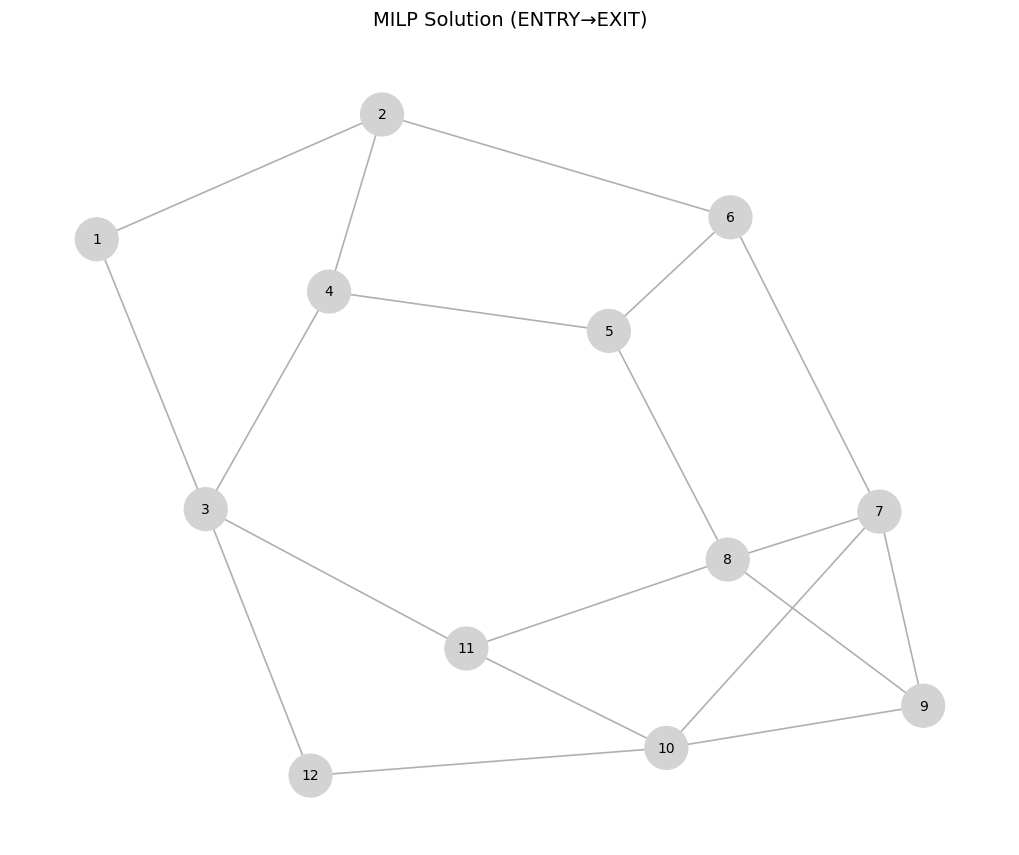

In [30]:
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi
from milp.create_instance import create_instance
from utils.generate_graphs import plot_solution_heuristic

# === 1. Criar instance ===
instance = create_instance(G, slices)
instance.entry_node = 6

# === 2. Rodar o MILP ===
milp_res = solve_gurobi(instance, msg=True, time_limit=3000)
# === 3. Adaptar e visualizar ===
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)
print(milp_adapter) 

plot_solution_heuristic(G, milp_adapter, title="MILP Solution (ENTRY→EXIT)")


[MILP-MULTI] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 3000
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads

Non-default parameters:
TimeLimit  3000
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Optimize a model with 0 rows, 1982 columns and 0 nonzeros (Min)
Model fingerprint: 0x804d38cb
Model has 122 linear objective coefficients
Variable types: 1231 cont

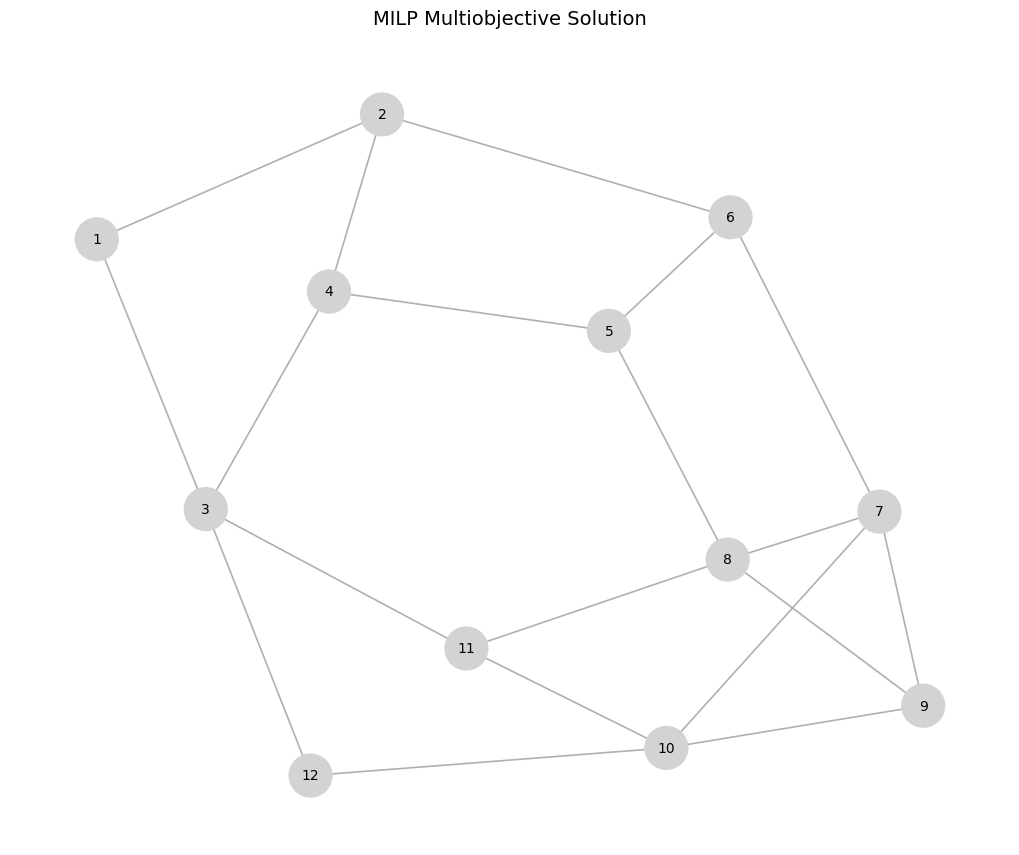

In [31]:
from milp.solver_gurobi_multiobjectif import solve_gurobi_multiobj   # <-- novo MILP
from milp.adapter import MILPResultAdapterGurobi
from milp.create_instance import create_instance
from utils.generate_graphs import plot_solution_heuristic

# === 1. Criar instance ===
instance = create_instance(G, slices)
instance.entry_node = 6

# === 2. Rodar o MILP MULTIOBJ ===
milp_res = solve_gurobi_multiobj(
    instance,
    msg=True,
    time_limit=3000,
    use_multiobj=True,         # ativa o multiobjetivo
    energy_priority=2,         # prioridade maior
    latency_priority=1         # prioridade menor
)

# === 3. Adaptar e visualizar ===
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)
print(milp_adapter)

plot_solution_heuristic(G, milp_adapter, title="MILP Multiobjective Solution")


In [32]:
import gurobipy as gp
m = gp.Model()
print("✅ Gurobi kernel is ready!")

✅ Gurobi kernel is ready!


In [33]:
# === Run MILP ===
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

instance = create_instance(G, slices)
milp_res = solve_gurobi(instance, msg=True, time_limit=120)
milp_multi_res = solve_gurobi_multiobj(instance, msg=True, time_limit=3000)


milp_adapter = MILPResultAdapterGurobi(milp_res, instance)
milp_multi_adapter = MILPResultAdapterGurobi(milp_multi_res, instance)

# === Add all methods to comparison dict ===
method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "A* Energy Aware": results_energy_aware_a_star,
    "First Fit": ff_results,
    "Best Fit": bestfit_results,
    "MILP (Gurobi)": [milp_adapter],   # ⚠️ important: wrap in list
    "MILP_multiobj": [milp_multi_adapter],
   

}


[MILP] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Optimize a model with 1173 rows, 1922 columns and 9873 nonzeros (Min)
Model fingerprint: 0x17deed41
Model has 62 linear objective coefficients
Variable types: 1171 continu

In [34]:
milp_res = solve_gurobi_multiobj(
    instance,
    msg=False,
    time_limit=300,
    use_multiobj=True,
    energy_priority=2,
    latency_priority=1,
    DEG_LIMIT=100,                     # grafo sem poda forte
    max_vnfs_per_slice_per_node=1,     # anti-colocation estrita
)


In [35]:
milp_res = solve_gurobi_multiobj(
    instance,
    msg=False,
    time_limit=300,
    use_multiobj=True,
    energy_priority=2,
    latency_priority=1,
    DEG_LIMIT=100,
    max_vnfs_per_slice_per_node=4,     # relaxa anti-colocation
)


In [36]:
from milp.solver_gurobi_multiobjectif import solve_gurobi_multiobj
from milp.adapter import MILPResultAdapterGurobi
from milp.create_instance import create_instance

def run_milp_with_admission_control(
    G,
    all_slices,
    time_limit=300,
    msg=True,
    num_orders=6,
):
    """
    Admission control wrapper around the multi-objective MILP.

    Tries several orders (permutations) of the slices and, for each order,
    progressively adds slices one by one, keeping only those that keep
    the MILP feasible. Returns the best combination of accepted slices.
    """

    import random

    best_accepted_indices = []
    best_instance = None
    best_adapter = None
    best_milp_res = None

    # Build different orders (you já tem algo assim, isso é só para consolidar)
    base_indices = list(range(len(all_slices)))
    orders = []

    # Order 1: natural order
    orders.append(base_indices[:])

    # Order 2: reverse
    orders.append(base_indices[::-1])

    # Orders 3..num_orders: random shuffles
    for _ in range(2, num_orders):
        perm = base_indices[:]
        random.shuffle(perm)
        orders.append(perm)

    for order_id, order in enumerate(orders, start=1):
        if msg:
            print(f"\n[ADMISSION] === Starting order {order_id}/{len(orders)} ({len(all_slices)} slices) ===")

        accepted_indices = []
        current_instance = None
        current_milp_res = None

        for step, slice_idx in enumerate(order, start=1):
            candidate_indices = accepted_indices + [slice_idx]
            candidate_slices = [all_slices[i] for i in candidate_indices]

            instance = create_instance(G, candidate_slices)
            instance.entry_node = 6  # ajuste se necessário

            if msg:
                print(f"[ADMISSION] Trying MILP with {len(candidate_slices)} slices "
                      f"(order {order_id}, step {step}/{len(order)}, slice_idx={slice_idx})")

            # ---- Chamada do multiobj com latência e banda soft ----
            milp_res = solve_gurobi_multiobj(
                instance,
                msg=False,  # deixe True se quiser ver o log detalhado do Gurobi
                time_limit=time_limit,
                use_multiobj=True,
                energy_priority=2,
                latency_priority=1,
                use_soft_latency=True,
                latency_slack_penalty=1000.0,
                use_soft_bandwidth=True,
                bandwidth_slack_penalty=500.0,
            )

            # Se retornar None, tratamos como infeasível
            if milp_res is None or milp_res.status_code not in [2, 9]:  # 2=OPTIMAL, 9=SUBOPTIMAL
                if msg:
                    print("[ADMISSION] Slice", slice_idx,
                          "rejected in order", order_id,
                          "(MILP infeasible or stopped).")
                continue

            # Caso contrário, aceitamos o slice
            accepted_indices = candidate_indices
            current_instance = instance
            current_milp_res = milp_res

            if msg:
                print(f"[ADMISSION] Slice {slice_idx} accepted in order {order_id}. "
                      f"Total accepted (this order): {len(accepted_indices)}")

        # Atualiza melhor solução global
        if len(accepted_indices) > len(best_accepted_indices):
            best_accepted_indices = accepted_indices
            best_instance = current_instance
            best_milp_res = current_milp_res
            best_adapter = MILPResultAdapterGurobi(best_milp_res, best_instance)

            if msg:
                print(f"[ADMISSION] >>> New best solution found in order {order_id}: "
                      f"{len(best_accepted_indices)} slices accepted.")

    return best_accepted_indices, best_instance, best_adapter, best_milp_res


In [37]:
# All comments in English

import gurobipy as gp
from gurobipy import GRB
from types import SimpleNamespace
from dataclasses import dataclass

@dataclass
class GurobiSolveResult:
    status_code: int
    status_str: str
    objective: float
    values: dict


# ===============================
# Helper: Build single-slice instance
# ===============================

def _build_single_slice_instance(
    instance, s, remaining_cpu_cap, remaining_bw_cap,
    astar_node_cands=None
):
    """
    Build a lightweight 'instance' object that only contains slice s
    using the CURRENT remaining capacities.
    """

    inst_s = SimpleNamespace()

    # --- Topology ---
    inst_s.N = instance.N
    inst_s.E = instance.E

    # --- Single slice ---
    inst_s.S = [s]

    # --- VNFs for this slice only ---
    inst_s.V_of_s = {s: instance.V_of_s[s]}

    # --- CPU ---
    inst_s.CPU_i = instance.CPU_i
    inst_s.CPU_cap = dict(remaining_cpu_cap)

    # --- Bandwidth ---
    inst_s.BW_cap = dict(remaining_bw_cap)

    # BW_sij restricted to this slice only
    if hasattr(instance, "BW_sij"):
        inst_s.BW_sij = {
            (ss, i, j): bw
            for (ss, i, j), bw in instance.BW_sij.items()
            if ss == s
        }
    else:
        inst_s.BW_sij = {}

    # Entry bandwidth
    if hasattr(instance, "BW_entry"):
        inst_s.BW_entry = {
            s: instance.BW_entry[s]
        } if s in instance.BW_entry else {}
    else:
        inst_s.BW_entry = {}

    # --- Latency budgets restricted to this slice ---
    inst_s.L_sij = {
        (ss, i, j): L
        for (ss, i, j), L in instance.L_sij.items()
        if ss == s
    } if hasattr(instance, "L_sij") else {}

    inst_s.L_entry = {
        s: instance.L_entry[s]
    } if hasattr(instance, "L_entry") and s in instance.L_entry else {}

    # --- Link latency ---
    inst_s.lat_e = instance.lat_e

    # --- Entry node ---
    if hasattr(instance, "entry_of_s"):
        inst_s.entry_of_s = {s: instance.entry_of_s.get(s, None)}
    if hasattr(instance, "entry_node"):
        inst_s.entry_node = instance.entry_node

    # -------------------------
    # FILTER A* CANDIDATES BY REMAINING CPU
    # -------------------------

    if astar_node_cands:
        filtered = {}
        for i, cand_nodes in astar_node_cands.items():

            # Keep only nodes that still have positive CPU
            good = [
                n for n in cand_nodes
                if remaining_cpu_cap.get(n, 0.0) > 0.0
            ]

            if good:
                filtered[i] = good

        inst_s.astar_node_cands = filtered

    # ----- Warm-start (optional) -----
    if hasattr(instance, "best_astar"):
        inst_s.best_astar = {s: instance.best_astar.get(s, {})}

    return inst_s



# ===============================
# Sequential MILP Solver
# ===============================

# All comments in English

def solve_gurobi_multiobj_sequential_basic(
    instance,
    msg=False,
    time_limit=None,
    DEG_LIMIT=100,
    MIP_GAP=0.05,
    use_multiobj=True,
    energy_priority=2,
    latency_priority=1,
    use_soft_latency=True,
    latency_slack_penalty=1000.0,
    max_vnfs_per_slice_per_node=1,
    warm_start=False,
):
    remaining_cpu_cap = dict(instance.CPU_cap)
    remaining_bw_cap = dict(instance.BW_cap)

    all_values = {}
    total_objective = 0.0
    last_status_code = GRB.OPTIMAL

    for s in instance.S:
        if msg:
            print(f"\n[SEQ-MILP] Solving slice {s} with remaining CPU {remaining_cpu_cap}")

        inst_s = _build_single_slice_instance(
            instance,
            s,
            remaining_cpu_cap,
            remaining_bw_cap,
            astar_node_cands=None,    # no A* hints here
        )

        res = solve_gurobi_multiobj(
            inst_s,
            msg=msg,
            time_limit=time_limit,
            DEG_LIMIT=DEG_LIMIT,
            MIP_GAP=MIP_GAP,
            use_multiobj=use_multiobj,
            energy_priority=energy_priority,
            latency_priority=latency_priority,
            use_soft_latency=use_soft_latency,
            latency_slack_penalty=latency_slack_penalty,
            max_vnfs_per_slice_per_node=max_vnfs_per_slice_per_node,
            astar_node_cands=None,
            astar_edge_cands=None,
            astar_entry_edge_cands=None,
            warm_start=warm_start,
        )

        if res is None:
            if msg:
                print(f"[SEQ-MILP] Slice {s} rejected (solver returned None).")
            last_status_code = GRB.INFEASIBLE
            continue

        last_status_code = res.status_code

        # Reject only clearly infeasible / unbounded cases
        if res.status_code in [GRB.INFEASIBLE, GRB.INF_OR_UNBD, GRB.UNBOUNDED]:
            if msg:
                print(f"[SEQ-MILP] Slice {s} rejected. Status={res.status_str}")
            continue

        if msg:
            print(f"[SEQ-MILP] Slice {s} accepted with status {res.status_str}.")

        all_values.update(res.values)

        if res.objective is not None:
            total_objective += res.objective

        # Update remaining capacities
        for key, val in res.values.items():
            if val is None or val <= 0:
                continue

            tag = key[0]

            if tag == "v":
                _, i, n = key
                cpu = inst_s.CPU_i[i]
                remaining_cpu_cap[n] = remaining_cpu_cap.get(n, 0.0) - cpu

            elif tag == "f":
                _, e, s_id, (i, j) = key
                bw = inst_s.BW_sij.get((s_id, i, j), 0.0)
                used = bw * val
                if e in remaining_bw_cap:
                    remaining_bw_cap[e] -= used
                elif (e[1], e[0]) in remaining_bw_cap:
                    remaining_bw_cap[(e[1], e[0])] -= used

            elif tag == "f_entry":
                _, e, s_id = key
                bw_e = inst_s.BW_entry.get(s_id, 0.0)
                used = bw_e * val
                if e in remaining_bw_cap:
                    remaining_bw_cap[e] -= used
                elif (e[1], e[0]) in remaining_bw_cap:
                    remaining_bw_cap[(e[1], e[0])] -= used

    return GurobiSolveResult(
        status_code=last_status_code,
        status_str="SEQUENTIAL",
        objective=total_objective,
        values=all_values,
    )


In [38]:
res = solve_gurobi_multiobj_sequential_basic(instance, msg=True, time_limit=300)



[SEQ-MILP] Solving slice 0 with remaining CPU {1: 64, 2: 16, 3: 16, 4: 16, 5: 16, 6: 64, 7: 16, 8: 16, 9: 16, 10: 16, 11: 64, 12: 16}
[MILP-MULTI] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 300
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Optimize a model with 0 rows, 

In [39]:
# All comments in English

# Map each VNF to its slice
vnf_to_slice = {}
for s in instance.S:
    for i in instance.V_of_s[s]:
        vnf_to_slice[i] = s

accepted_slices = set()
all_slices = set(instance.S)

for key, val in res.values.items():
    if key[0] == "v" and val > 0.5:
        _, i, n = key
        s = vnf_to_slice[i]
        accepted_slices.add(s)

rejected_slices = all_slices - accepted_slices

print("=== Sequential MILP result ===")
print(f"Total slices:    {len(all_slices)}")
print(f"Accepted slices: {len(accepted_slices)} -> {sorted(accepted_slices)}")
print(f"Rejected slices: {len(rejected_slices)} -> {sorted(rejected_slices)}")


=== Sequential MILP result ===
Total slices:    20
Accepted slices: 0 -> []
Rejected slices: 20 -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [40]:
# All comments in English

# Build single-slice instance for slice 0 with full capacities
inst_s0 = _build_single_slice_instance(
    instance,
    s=0,
    remaining_cpu_cap=instance.CPU_cap,
    remaining_bw_cap=instance.BW_cap,
    astar_node_cands=None,   # no A* hints for now
)

# Solve MILP for just this slice
res0 = solve_gurobi_multiobj(
    inst_s0,
    msg=True,          # show Gurobi log
    time_limit=120,
)

print("\n=== Single-slice MILP for slice 0 ===")
print("status_code:", res0.status_code)
print("status_str: ", res0.status_str)
print("objective:  ", res0.objective)
print("has values: ", len(res0.values))


[MILP-MULTI] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Optimize a model with 0 rows, 158 columns and 0 nonzeros (Min)
Model fingerprint: 0xcb93c460
Model has 65 linear objective coefficients
Variable types: 91 continuous

In [41]:
# All comments in English

# Build single-slice instance for slice 0 with full capacities
inst_s0 = _build_single_slice_instance(
    instance,
    s=0,
    remaining_cpu_cap=instance.CPU_cap,
    remaining_bw_cap=instance.BW_cap,
    astar_node_cands=None,   # no A* hints
)

# Solve MILP for just this slice
res0 = solve_gurobi_multiobj(
    inst_s0,
    msg=True,          # show Gurobi log
    time_limit=120,
)

print("\n=== Single-slice MILP for slice 0 ===")
print("status_code:", res0.status_code)
print("status_str: ", res0.status_str)
print("objective:  ", res0.objective)
print("has values: ", len(res0.values))


[MILP-MULTI] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Optimize a model with 0 rows, 158 columns and 0 nonzeros (Min)
Model fingerprint: 0xcb93c460
Model has 65 linear objective coefficients
Variable types: 91 continuous

In [42]:
# All comments in English

s = 0

print("=== Latency budgets for slice 0 ===")

# Entry latency budget, if any
if hasattr(instance, "L_entry"):
    print("L_entry[0] =", instance.L_entry.get(s, "not defined"))
else:
    print("No L_entry in instance.")

# Latency budgets for each virtual link of slice 0
if hasattr(instance, "L_sij"):
    for (ss, i, j), L in instance.L_sij.items():
        if ss == s:
            print(f"L_sij[{s}, {i}, {j}] = {L}")
else:
    print("No L_sij in instance.")


=== Latency budgets for slice 0 ===
L_entry[0] = 120.0
L_sij[0, vnf0_0, vnf0_1] = 120.0
L_sij[0, vnf0_1, vnf0_2] = 180.0


In [43]:
# All comments in English

print("=== Routing graph seen by MILP (global) ===")
print("Nodes:", list(instance.N))
print("Edges:", list(instance.E))

print("\nCPU capacities per node:")
for n in instance.N:
    print(f"  Node {n}: CPU_cap = {instance.CPU_cap[n]}")

print("\nAny nodes with zero CPU?")
zero_nodes = [n for n in instance.N if instance.CPU_cap[n] <= 0]
print(zero_nodes)


=== Routing graph seen by MILP (global) ===
Nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Edges: [(1, 2), (1, 3), (2, 4), (2, 6), (3, 4), (3, 11), (3, 12), (4, 5), (5, 6), (5, 8), (6, 7), (7, 8), (7, 9), (7, 10), (8, 9), (8, 11), (9, 10), (10, 11), (10, 12)]

CPU capacities per node:
  Node 1: CPU_cap = 64
  Node 2: CPU_cap = 16
  Node 3: CPU_cap = 16
  Node 4: CPU_cap = 16
  Node 5: CPU_cap = 16
  Node 6: CPU_cap = 64
  Node 7: CPU_cap = 16
  Node 8: CPU_cap = 16
  Node 9: CPU_cap = 16
  Node 10: CPU_cap = 16
  Node 11: CPU_cap = 64
  Node 12: CPU_cap = 16

Any nodes with zero CPU?
[]


In [44]:
# All comments in English

import networkx as nx

# Build latency-weighted graph from instance
G_lat = nx.Graph()
for (u, v) in instance.E:
    lat = float(instance.lat_e.get((u, v), instance.lat_e.get((v, u), 1.0)))
    G_lat.add_edge(u, v, latency=lat)

s = 0
entry = instance.entry_of_s[s]
vnfs = instance.V_of_s[s]

print(f"Slice {s}, entry node = {entry}")
print("VNFs:", vnfs)

# Shortest latency from entry to each node
print("\n=== Shortest latency from entry to all nodes ===")
dist = nx.single_source_dijkstra_path_length(G_lat, entry, weight="latency")
for n, d in sorted(dist.items()):
    print(f"Entry -> Node {n}: latency = {d}")

# Check if for each VL (i->j) there exists some pair of nodes (n_i, n_j)
# with latency within budget (pure topological check, ignoring CPU/BW)
print("\n=== Feasibility check per virtual link (topology + latency only) ===")

for (ss, i, j), L in instance.L_sij.items():
    if ss != s:
        continue

    feasible_pair = False
    for n_i in instance.N:
        for n_j in instance.N:
            if n_i == n_j:
                continue
            try:
                d_ij = nx.dijkstra_path_length(G_lat, n_i, n_j, weight="latency")
                if d_ij <= L:
                    feasible_pair = True
                    break
            except nx.NetworkXNoPath:
                continue
        if feasible_pair:
            break

    print(f"VL {i}->{j} with budget {L}:",
          "OK (some path <= L)" if feasible_pair else "NO PATH <= L")


Slice 0, entry node = 6
VNFs: ['vnf0_0', 'vnf0_1', 'vnf0_2']

=== Shortest latency from entry to all nodes ===
Entry -> Node 1: latency = 2.0
Entry -> Node 2: latency = 1.0
Entry -> Node 3: latency = 3.0
Entry -> Node 4: latency = 2.0
Entry -> Node 5: latency = 1.0
Entry -> Node 6: latency = 0
Entry -> Node 7: latency = 1.0
Entry -> Node 8: latency = 2.0
Entry -> Node 9: latency = 2.0
Entry -> Node 10: latency = 2.0
Entry -> Node 11: latency = 3.0
Entry -> Node 12: latency = 3.0

=== Feasibility check per virtual link (topology + latency only) ===
VL vnf0_0->vnf0_1 with budget 120.0: OK (some path <= L)
VL vnf0_1->vnf0_2 with budget 180.0: OK (some path <= L)


In [45]:
# All comments in English

print("solve_gurobi_multiobj is defined at line:",
      solve_gurobi_multiobj.__code__.co_firstlineno,
      "in file:", solve_gurobi_multiobj.__code__.co_filename)


solve_gurobi_multiobj is defined at line: 26 in file: /home/cecilia/5g-slicing-energy-effiiciency/simulator/milp/solver_gurobi_multiobjectif.py


In [46]:
# All comments in English

# Build single-slice instance for slice 0 with full capacities
inst_s0 = _build_single_slice_instance(
    instance,
    s=0,
    remaining_cpu_cap=instance.CPU_cap,
    remaining_bw_cap=instance.BW_cap,
    astar_node_cands=None,   # start without A* hints
)

# Solve MILP for just this slice
res0 = solve_gurobi_multiobj(
    inst_s0,
    msg=True,          # show Gurobi log
    time_limit=120,
)

print("\n=== Single-slice MILP for slice 0 ===")
print("status_code:", res0.status_code)
print("status_str: ", res0.status_str)
print("objective:  ", res0.objective)
print("has values: ", len(res0.values))


[MILP-MULTI] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Optimize a model with 0 rows, 158 columns and 0 nonzeros (Min)
Model fingerprint: 0xcb93c460
Model has 65 linear objective coefficients
Variable types: 91 continuous

In [47]:
# All comments in English

s = 0
vnfs = instance.V_of_s[s]

total_cpu_req = sum(instance.CPU_i[i] for i in vnfs)
total_cpu_cap = sum(instance.CPU_cap[n] for n in instance.N)

print(f"Slice {s} CPU required:", total_cpu_req)
print("Total CPU capacity:    ", total_cpu_cap)

# BW requirements for each virtual link of slice 0
print("\nVirtual links BW for slice 0:")
if hasattr(instance, "BW_sij"):
    for (ss, i, j), bw in instance.BW_sij.items():
        if ss == s:
            print(f"  VL {i}->{j}: BW = {bw}")
else:
    print("  No BW_sij in instance.")

# Max BW capacity on any physical link
max_bw_cap = max(instance.BW_cap.values())
print("\nMax physical link BW capacity:", max_bw_cap)


Slice 0 CPU required: 12
Total CPU capacity:     336

Virtual links BW for slice 0:
  VL vnf0_0->vnf0_1: BW = 40.0
  VL vnf0_1->vnf0_2: BW = 50.0

Max physical link BW capacity: 1000


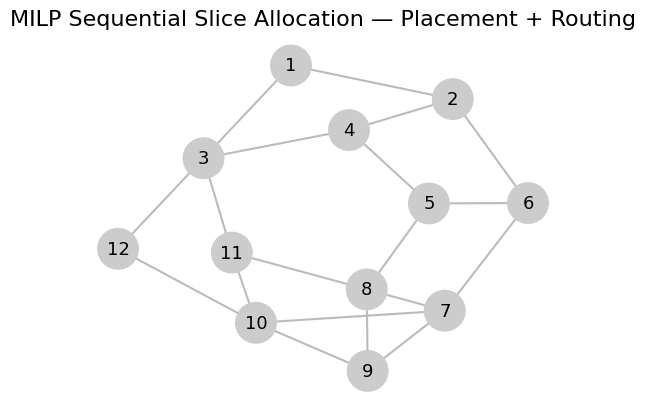

In [48]:
# ==============================
# Plotting of MILP solution
# All comments in English
# ==============================

import networkx as nx
import matplotlib.pyplot as plt

def plot_solution(instance, res):
    """
    Plot the placement of VNFs and the routed virtual links
    after a sequential MILP allocation.
    """

    # --- Build base graph ---
    G = nx.Graph()
    for (u, v) in instance.E:
        G.add_edge(u, v)

    pos = nx.spring_layout(G, seed=42)   # layout for visualization

    # --- Identify active nodes ---
    active_nodes = set()
    for key, val in res.values.items():
        if key[0] == "v" and val > 0.5:
            _, _, n = key   # ("v", i, n)
            active_nodes.add(n)

    # --- Identify active links ---
    active_edges = set()
    for key, val in res.values.items():
        if key[0] == "f" and val > 0.0:
            _, e, _, _ = key
            active_edges.add(e)
        if key[0] == "f_entry" and val > 0.0:
            _, e, _ = key
            active_edges.add(e)

    # Normalize edges (u,v) ordering
    active_edges = {(min(u, v), max(u, v)) for (u,v) in active_edges}

    # --- Draw nodes: active in green, inactive in light gray ---
    node_colors = ["#4CAF50" if n in active_nodes else "#CCCCCC" for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=850)

    # --- Draw all edges in light gray ---
    nx.draw_networkx_edges(G, pos, width=1.5, edge_color="#BBBBBB")

    # --- Highlight active edges in red ---
    nx.draw_networkx_edges(
        G, pos,
        edgelist=list(active_edges),
        width=3.0,
        edge_color="red"
    )

    # --- Node labels ---
    nx.draw_networkx_labels(G, pos, font_size=13, font_color="black")

    # --- Annotate VNF placements ---
    vnf_labels = {}
    for key, val in res.values.items():
        if key[0] == "v" and val > 0.5:
            _, i, n = key
            vnf_labels.setdefault(n, []).append(str(i))

    # Add VNF names next to nodes
    for n, vnfs in vnf_labels.items():
        x, y = pos[n]
        label = ",".join(vnfs)
        plt.text(
            x, y - 0.08,
            f"VNFs: {label}",
            fontsize=10,
            ha='center'
        )

    plt.title("MILP Sequential Slice Allocation — Placement + Routing", fontsize=16)
    plt.axis("off")
    plt.show()


# =============================
# Run the plot
# =============================

plot_solution(instance, res)



In [49]:
# All comments in English

# 1) Build a mapping: VNF id -> slice id
vnf_to_slice = {}
for s in instance.S:
    for i in instance.V_of_s[s]:
        vnf_to_slice[i] = s

# 2) Scan solution and mark which slices have at least one VNF placed
accepted_slices = set()

for key, val in res.values.items():
    if key[0] == "v" and val > 0.5:   # ("v", i, n)
        _, i, n = key
        s = vnf_to_slice.get(i, None)
        if s is not None:
            accepted_slices.add(s)

# 3) Count accepted and rejected
total_slices = len(instance.S)
num_accepted = len(accepted_slices)
num_rejected = total_slices - num_accepted

print(f"Total slices: {total_slices}")
print(f"Accepted slices: {num_accepted}")
print(f"Rejected slices: {num_rejected}")
print(f"Accepted slice IDs: {sorted(accepted_slices)}")



Total slices: 20
Accepted slices: 0
Rejected slices: 20
Accepted slice IDs: []


In [50]:
# All comments in English

# Build mapping VNF -> slice
vnf_to_slice = {}
for s in instance.S:
    for i in instance.V_of_s[s]:
        vnf_to_slice[i] = s

print("=== VNF placements (node 6 marked) ===")
for key, val in res.values.items():
    if key[0] == "v" and val > 0.5:  # ("v", i, n)
        _, i, n = key
        s = vnf_to_slice.get(i, None)
        mark = " <-- ENTRY NODE" if n == 6 else ""
        print(f"Slice {s}, VNF {i} -> Node {n}{mark}")


=== VNF placements (node 6 marked) ===


In [51]:
def debug_milp_solution(milp_res, instance):
    vals = milp_res.values

    # --- CPU por nó ---
    cpu_used = {n: 0.0 for n in instance.N}
    for key, val in vals.items():
        if key[0] == "v" and val > 1e-6:  # ("v", i, n)
            _, i, n = key
            cpu_used[n] += instance.CPU_i[i]

    print("=== CPU usage per node ===")
    for n in instance.N:
        print(
            f"Node {n}: used={cpu_used[n]:.1f} / cap={instance.CPU_cap[n]:.1f}"
        )

    # --- Banda por link ---
    bw_used = {}
    for e in instance.E:
        bw_used[e] = 0.0

    for key, val in vals.items():
        if key[0] == "f" and val > 1e-6:
            # key = ("f", (u,v), s, (i,j))
            _, e, s, (i, j) = key
            bw = instance.BW_sij[(s, i, j)]
            bw_used[e] += bw * val

        if key[0] == "f_entry" and val > 1e-6:
            _, e, s = key
            bw = instance.BW_entry.get(s, 0.0)
            bw_used[e] += bw * val

    print("\n=== Bandwidth usage per edge ===")
    for e in instance.E:
        cap = instance.BW_cap.get(e, instance.BW_cap.get((e[1], e[0]), 0.0))
        print(
            f"Edge {e}: used={bw_used[e]:.1f} / cap={cap:.1f}"
        )

    # --- Slacks de latência (para ver se estamos “forçando” muito) ---
    print("\n=== Latency slacks (VLs) ===")
    for key, val in vals.items():
        if key[0] == "slack_lat" and val > 1e-6:
            _, s, i, j = key
            print(f"Slice {s}, ({i}->{j}): slack={val:.3f}")

    print("\n=== Latency slacks (ENTRY) ===")
    for key, val in vals.items():
        if key[0] == "slack_lat_entry" and val > 1e-6:
            _, s = key
            print(f"Slice {s}: entry slack={val:.3f}")


In [29]:
debug_milp_solution(milp_adm_res, instance_milp_adm)


=== CPU usage per node ===
Node 1: used=0.0 / cap=64.0
Node 2: used=0.0 / cap=16.0
Node 3: used=0.0 / cap=16.0
Node 4: used=0.0 / cap=16.0
Node 5: used=0.0 / cap=16.0
Node 6: used=24.0 / cap=64.0
Node 7: used=16.0 / cap=16.0
Node 8: used=16.0 / cap=16.0
Node 9: used=12.0 / cap=16.0
Node 10: used=16.0 / cap=16.0
Node 11: used=60.0 / cap=64.0
Node 12: used=0.0 / cap=16.0

=== Bandwidth usage per edge ===
Edge (1, 2): used=0.0 / cap=1000.0
Edge (1, 3): used=0.0 / cap=250.0
Edge (2, 4): used=0.0 / cap=500.0
Edge (2, 6): used=0.0 / cap=500.0
Edge (3, 4): used=0.0 / cap=500.0
Edge (3, 11): used=0.0 / cap=500.0
Edge (3, 12): used=0.0 / cap=500.0
Edge (4, 5): used=0.0 / cap=500.0
Edge (5, 6): used=0.0 / cap=500.0
Edge (5, 8): used=0.0 / cap=1000.0
Edge (6, 7): used=480.0 / cap=500.0
Edge (7, 8): used=260.0 / cap=500.0
Edge (7, 9): used=100.0 / cap=1000.0
Edge (7, 10): used=160.0 / cap=1000.0
Edge (8, 9): used=0.0 / cap=1000.0
Edge (8, 11): used=300.0 / cap=1000.0
Edge (9, 10): used=0.0 / cap=5

In [30]:
def check_flows_nonzero(milp_res):
    vals = milp_res.values
    num_f = sum(1 for k, v in vals.items() if k[0] == "f" and v > 1e-6)
    num_f_entry = sum(1 for k, v in vals.items() if k[0] == "f_entry" and v > 1e-6)
    print(f"Non-zero f variables: {num_f}")
    print(f"Non-zero f_entry variables: {num_f_entry}")

check_flows_nonzero(milp_adm_res)


Non-zero f variables: 34
Non-zero f_entry variables: 0


In [25]:
total_cpu_demand = 0.0
for s_id, sl in enumerate(slices):
    for vnf in sl[0]:
        total_cpu_demand += vnf["cpu"]

total_cpu_capacity = sum(instance.CPU_cap[n] for n in instance.N)

print("Total CPU demand of all slices:", total_cpu_demand)
print("Total CPU capacity:", total_cpu_capacity)


Total CPU demand of all slices: 240.0
Total CPU capacity: 336


In [26]:
# All comments in English
total_bw_demand = 0.0

for s_id, sl in enumerate(slices):
    # VNFs dessa slice
    vnf_list = sl[0]
    # pares (i,j) dessa slice como na instance
    vnf_ids = instance.V_of_s[s_id]
    for k in range(len(vnf_ids) - 1):
        i = vnf_ids[k]
        j = vnf_ids[k + 1]
        bw = instance.BW_sij.get((s_id, i, j), 0.0)
        total_bw_demand += bw

print("Total bandwidth demand (sum over all VLs):", total_bw_demand)

total_bw_capacity = sum(instance.BW_cap[e] for e in instance.E)
print("Total bandwidth capacity (sum over all edges):", total_bw_capacity)


Total bandwidth demand (sum over all VLs): 1800.0
Total bandwidth capacity (sum over all edges): 12750


In [23]:
from utils.metrics import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_energy_new,
    compute_milp_bandwidth_latency,
    count_accepted_slices,
)

# Map each MILP-like method to its corresponding raw Gurobi result
milp_result_map = {
    "MILP": milp_res,                    # classical single-objective MILP
    "MILP_multiobj": milp_multi_res,     # multi-objective MILP (all slices)
    "MILP_admission": milp_adm_res       # MILP with admission control (subset of slices)
}

# Map each MILP-like method to the instance used in that solve
milp_instance_map = {
    "MILP": instance,                    # instance with all slices
    "MILP_multiobj": instance,          # same instance (if você usou o mesmo)
    "MILP_admission": instance_milp_adm # instance with only accepted slices
}

comparison_rows = []

for method_name, result_list in method_results.items():
    if not result_list:
        continue

    # --- Energy metrics (for all methods, incluindo MILP adapters) ---
    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, _ = compute_energy_per_node(result_list, slices, node_capacity_base)
    normalized_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)

    # --- Bandwidth & Latency ---
    if method_name in milp_result_map and len(result_list) == 1:
        # Dedicated MILP metrics using the raw Gurobi result
        total_bw, total_lat, _, _ = compute_milp_bandwidth_latency(
            milp_result_map[method_name],
            milp_instance_map[method_name]
        )
    else:
        # Heuristics (A*, ABO, FABO, etc.) computed from result_list
        total_bw_list = compute_total_bandwidth(result_list, slices)
        total_lat_list = compute_total_latency(result_list, link_latency)
        total_bw = sum(b for b in total_bw_list if b is not None)
        total_lat = sum(l for l in total_lat_list if l is not None)

    # --- Build comparison row ---
    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": count_accepted_slices(result_list, slices, verbose=False),
        "Total Bandwidth": total_bw,
        "Total Latency": total_lat,
        "Total Energy": normalized_energy,
    })

# --- Final DataFrame ---
df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)


Method  Slices Accepted  Total Bandwidth  Total Latency  \
0               A*               20           2320.0           52.0   
1              ABO               20           2630.0           95.0   
2             FABO               20           2600.0           92.0   
3  A* Energy Aware               20           2320.0           58.0   
4        First Fit               20           3270.0           97.0   
5         Best Fit               17           1880.0           42.0   
6    MILP (Gurobi)                0              0.0            0.0   
7    MILP_multiobj                0              0.0            0.0   
8   MILP_admission               12           1500.0           34.0   

   Total Energy  
0      37.36375  
1      54.57000  
2      56.57000  
3      44.89000  
4      47.06750  
5      32.81000  
6       0.00000  
7       0.00000  
8      19.50250

In [23]:
df_milp = pd.DataFrame([
    {
        "slice": len(slices),      # número total de slices
        "accepted": True if milp_adapter else False,
        "g_cost": milp_res.objective if milp_res.objective else None
    }
])


In [24]:
from datetime import datetime

num_slices = len(slices)
num_vnfs_total = sum(len(v[0]) for v in slices)

summary_info = {
    "timestamp": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    "num_slices": [num_slices],
    "num_vnfs_total": [num_vnfs_total]
}

import pandas as pd
df_info = pd.DataFrame(summary_info)
df_info.to_csv(f"{results_dir}/experiment_info.csv", index=False)
df_astar.to_csv(f"{results_dir}/astar_results.csv", index=False)
df_energy_aware_a_star.to_csv(f"{results_dir}/energy_aware_a_star.csv", index=False)
df_abo.to_csv(f"{results_dir}/abo_results.csv", index=False)
df_fabo.to_csv(f"{results_dir}/fabo_results.csv", index=False)
df_bestfit.to_csv(f"{results_dir}/bestfit_results.csv", index=False)
df_ff.to_csv(f"{results_dir}/ff_results.csv", index=False)
df_milp.to_csv(f"{results_dir}/milp_results.csv", index=False)
df_metrics.to_csv(f"{results_dir}/metrics.csv", index=False)


In [25]:
with open(f"{results_dir}/log.txt", "w") as f:
    f.write(f"Experiment timestamp: {datetime.now()}\n")
    f.write(f"Number of slices: {num_slices}\n")
    f.write(f"Number of VNFs: {num_vnfs_total}\n")
    f.write("\n=== Summary ===\n")
    f.write(df_astar.to_string(index=False))
    f.write(df_abo.to_string(index=False))
    f.write(df_fabo.to_string(index=False))
    f.write(df_energy_aware_a_star.to_string(index=False))
    f.write(df_bestfit.to_string(index=False))
    f.write(df_ff.to_string(index=False))
    f.write(df_metrics.to_string(index=False))
    f.write("\n\n=== MILP ===\n")
    f.write(df_milp.to_string(index=False))

In [26]:
from utils.generate_graphs import plot_cpu_usage
plot_cpu_usage(G, slices, method_results, results_dir)


[INFO] Saved CPU utilization chart to results/2025-11-17_10-38-38/cpu_utilization.png


In [27]:
from milp.helpers import sanity_check_milp_gurobi
sanity_check_milp_gurobi(milp_res, instance, slices)

=== Sanity check MILP (Gurobi) ===
Objective value: 10.550
Status: 2

Node CPU usage:
  Node 1: used 0.00 / cap 64.00 
  Node 2: used 0.00 / cap 16.00 
  Node 3: used 0.00 / cap 16.00 
  Node 4: used 0.00 / cap 16.00 
  Node 5: used 0.00 / cap 16.00 
  Node 6: used 12.00 / cap 64.00 
  Node 7: used 8.00 / cap 16.00 
  Node 8: used 16.00 / cap 16.00 
  Node 9: used 0.00 / cap 16.00 
  Node 10: used 0.00 / cap 16.00 
  Node 11: used 36.00 / cap 64.00 
  Node 12: used 0.00 / cap 16.00 

[Slice 0]
  VNF vnf0_0 → Node(s) [6]
  VNF vnf0_1 → Node(s) [8]
  VNF vnf0_2 → Node(s) [11]
  VL (vnf0_0->vnf0_1) ✓ routed via [(6, 7), (7, 8)]
  VL (vnf0_1->vnf0_2) ✓ routed via [(8, 11)]
  → Slice 0 ACCEPTED ✓

[Slice 1]
  VNF vnf1_0 → Node(s) [6]
  VNF vnf1_1 → Node(s) [8]
  VNF vnf1_2 → Node(s) [11]
  VL (vnf1_0->vnf1_1) ✓ routed via [(6, 7), (7, 8)]
  VL (vnf1_1->vnf1_2) ✓ routed via [(8, 11)]
  → Slice 1 ACCEPTED ✓

[Slice 2]
  VNF vnf2_0 → Node(s) [6]
  VNF vnf2_1 → Node(s) [8]
  VNF vnf2_2 → Node(s

# Load and scalability 

### heuristics

In [ ]:
# === Load & Scalability Experiment ===
# All comments in English

import os, random, time
import numpy as np
import pandas as pd
from copy import deepcopy
from datetime import datetime

# --- Imports ---
from utils.topology import topology_brazil, topologie_finlande
from utils.generate_slices import generate_random_slices
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.a_star_energy_aware import energy_aware_astar
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit

from utils.metrics import (
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
    count_accepted_slices,
)

# --- Output directory ---
results_dir =results_dir
os.makedirs(results_dir, exist_ok=True)

# --- Topology ---
G = topology_brazil()
ENTRY = 6

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid ---
param_grid = {
    "num_slices": [4,6, 8, 10 ,12, 16, 18, 20, 32, 64 ],
    "num_vnfs_per_slice": [2, 3, 4],
    "seed": [1],
}

records = []

for num_slices in param_grid["num_slices"]:
    for num_vnfs in param_grid["num_vnfs_per_slice"]:
        for seed in param_grid["seed"]:
            random.seed(seed)
            np.random.seed(seed)

            print(f"\n[INFO] === Running Load Test: {num_slices} slices, {num_vnfs} VNFs, seed={seed} ===")

            # --- Generate slices ---
            slices = generate_random_slices(
                    G,
                    vnf_profiles,
                    num_slices=num_slices,
                    num_vnfs_per_slice=num_vnfs,
                    entry=ENTRY
                )


            # --- Run heuristics ---
            method_results = {}
            method_times = {}

            for name, func, args in [
                ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("Energy-Aware A*", energy_aware_astar,
 (G, slices, node_capacity_base, link_capacity_base,
  0.6, 0.4))


            ]:
                start = time.time()
                try:
                    df_res, res_list = func(*args)
                    method_results[name] = res_list
                except Exception as e:
                    print(f"[ERROR] {name} failed: {e}")
                    method_results[name] = []
                method_times[name] = time.time() - start

            # --- Compute metrics ---
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })


Loaded RNP Brazil topology with 28 nodes and 31 links.
CPU distribution: 2×128, 4×64, 8×32, 14×16
Average CPU: 35.4 | Avg BW: 7853 Mbps | Avg latency: 3.73 ms

[INFO] === Running Load Test: 4 slices, 2 VNFs, seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 4 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 4 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 4 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 4 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][ABO] === Solving slice 1 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 4 states.
[SUMMARY][ABO] Slice 1 accepted. min_node_cpu=14, links_low_bw=0

[INFO][ABO] === Solving slice 2 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solutio

In [55]:

# --- Save & preview ---
df_load = pd.DataFrame(records)
output_path = os.path.join(results_dir, "load_scalability_results.csv")
df_load.to_csv(output_path, index=False)
print(f"\n[INFO] Results saved to {output_path}")
display(df_load)



[INFO] Results saved to results/2025-11-12_15-33-38/load_scalability_results.csv


timestamp  num_slices  num_vnfs_per_slice  seed  \
0    2025-11-12 15:34:52           4                   2     1   
1    2025-11-12 15:34:52           4                   2     1   
2    2025-11-12 15:34:52           4                   2     1   
3    2025-11-12 15:34:52           4                   2     1   
4    2025-11-12 15:34:52           4                   2     1   
..                   ...         ...                 ...   ...   
175  2025-11-12 15:44:18          64                   4     1   
176  2025-11-12 15:44:18          64                   4     1   
177  2025-11-12 15:44:18          64                   4     1   
178  2025-11-12 15:44:18          64                   4     1   
179  2025-11-12 15:44:18          64                   4     1   

              method  accepted  total_energy  total_bandwidth  total_latency  \
0                 A*         4      4.264057            160.0       4.027414   
1                ABO         4      4.014057            160.0       8.054828   
2               FABO         0      3.500000              0.0       4.027414   
3           Best Fit         4     19.609731           1280.0     126.143911   
4          First Fit         4     11.609731           1280.0     164.164467   
..               ...       ...           ...              ...            ...   
175              ABO        49     99.937191          10200.0     997.651907   
176             FABO        46    101.798944          10450.0    1006.007587   
177         Best Fit        38    114.166455          16500.0    1674.104692   
178        First Fit        42    109.148646          15840.0    1442.689558   
179  Energy-Aware A*        49    107.979493          10130.0    1058.505446   

     runtime_sec  
0       0.032832  
1       0.197445  
2       0.130634  
3       0.001547  
4       0.002433  
..           ...  
175    19.598590  
176    19.824791  
177     0.047238  
178     0.049159  
179    82.393027  

[180 rows x 10 columns]

In [56]:
# --- Load results CSV produced by your experiment generator ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Adjust this path to your saved file
csv_path = output_path
df = pd.read_csv(csv_path)

# Basic type coercion
num_cols = [
    "num_slices","num_vnfs_per_slice","seed","accepted",
    "total_energy","total_bandwidth","total_latency","runtime_sec"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Useful derived metrics
df["energy_per_accepted"]  = np.where(df["accepted"]>0, df["total_energy"]/df["accepted"], np.nan)
df["latency_per_accepted"] = np.where(df["accepted"]>0, df["total_latency"]/df["accepted"], np.nan)

df


timestamp  num_slices  num_vnfs_per_slice  seed  \
0    2025-11-12 15:34:52           4                   2     1   
1    2025-11-12 15:34:52           4                   2     1   
2    2025-11-12 15:34:52           4                   2     1   
3    2025-11-12 15:34:52           4                   2     1   
4    2025-11-12 15:34:52           4                   2     1   
..                   ...         ...                 ...   ...   
175  2025-11-12 15:44:18          64                   4     1   
176  2025-11-12 15:44:18          64                   4     1   
177  2025-11-12 15:44:18          64                   4     1   
178  2025-11-12 15:44:18          64                   4     1   
179  2025-11-12 15:44:18          64                   4     1   

              method  accepted  total_energy  total_bandwidth  total_latency  \
0                 A*         4      4.264057            160.0       4.027414   
1                ABO         4      4.014057            160.0       8.054828   
2               FABO         0      3.500000              0.0       4.027414   
3           Best Fit         4     19.609731           1280.0     126.143911   
4          First Fit         4     11.609731           1280.0     164.164467   
..               ...       ...           ...              ...            ...   
175              ABO        49     99.937191          10200.0     997.651907   
176             FABO        46    101.798944          10450.0    1006.007587   
177         Best Fit        38    114.166455          16500.0    1674.104692   
178        First Fit        42    109.148646          15840.0    1442.689558   
179  Energy-Aware A*        49    107.979493          10130.0    1058.505446   

     runtime_sec  energy_per_accepted  latency_per_accepted  
0       0.032832             1.066014              1.006853  
1       0.197445             1.003514              2.013707  
2       0.130634                  NaN                   NaN  
3       0.001547             4.902433             31.535978  
4       0.002433             2.902433             41.041117  
..           ...                  ...                   ...  
175    19.598590             2.039535             20.360243  
176    19.824791             2.213021             21.869730  
177     0.047238             3.004380             44.055387  
178     0.049159             2.598777             34.349751  
179    82.393027             2.203663             21.602152  

[180 rows x 12 columns]

In [57]:
# --- Acceptance-aware utilities (STRICT and NORMALIZED views) ---

def _aggregate_scenario(d, aggregate_over_seeds=True):
    """Aggregate rows for a fixed (num_slices, num_vnfs_per_slice) scenario."""
    if aggregate_over_seeds:
        out = (d.groupby("method", as_index=False)
                 .agg(total_energy=("total_energy","mean"),
                      total_latency=("total_latency","mean"),
                      runtime_sec=("runtime_sec","mean"),
                      total_bandwidth=("total_bandwidth","mean"),
                      accepted=("accepted","mean"),
                      energy_per_accepted=("energy_per_accepted","mean"),
                      latency_per_accepted=("latency_per_accepted","mean")))
    else:
        # If you want to keep per-seed, you can drop this mean and handle outside
        out = d.copy()
    return out

def fair_percentages_for_scenario(df, slices_target, vnfs_target, baseline="A*", aggregate_over_seeds=True):
    """
    Build STRICT and NORMALIZED percentage comparisons for a single scenario (num_slices, num_vnfs_per_slice).
    STRICT: only methods that reached max acceptance (apple-to-apple).
    NORMALIZED: all methods with energy scaled to the same acceptance (max) -> conservative penalty.
    """
    d = df[(df["num_slices"]==slices_target) & (df["num_vnfs_per_slice"]==vnfs_target)].copy()
    if d.empty:
        raise ValueError("No rows for the requested scenario.")

    agg = _aggregate_scenario(d, aggregate_over_seeds=aggregate_over_seeds).copy()
    # Handle rounding noise on accepted when averaged across seeds
    agg["accepted_round"] = agg["accepted"].round(6)
    max_acc = agg["accepted_round"].max()

    # -------- STRICT (only max acceptance) --------
    strict = agg[agg["accepted_round"] == max_acc].copy()
    if not strict.empty:
        worst_E = strict["total_energy"].max()
        worst_L = strict["total_latency"].max()
        worst_T = strict["runtime_sec"].max()

        strict["gain_energy_vs_worst_%"]  = (worst_E - strict["total_energy"]) / worst_E * 100.0
        strict["gain_latency_vs_worst_%"] = (worst_L - strict["total_latency"]) / worst_L * 100.0
        strict["gain_runtime_vs_worst_%"] = (worst_T - strict["runtime_sec"]) / worst_T * 100.0

        if baseline in strict["method"].values:
            b = strict.loc[strict["method"]==baseline].iloc[0]
            strict["gain_energy_vs_baseline_%"]  = (b["total_energy"]  - strict["total_energy"])  / b["total_energy"]  * 100.0
            strict["gain_latency_vs_baseline_%"] = (b["total_latency"] - strict["total_latency"]) / b["total_latency"] * 100.0
            strict["gain_runtime_vs_baseline_%"] = (b["runtime_sec"]   - strict["runtime_sec"])   / b["runtime_sec"]   * 100.0
        else:
            strict[["gain_energy_vs_baseline_%","gain_latency_vs_baseline_%","gain_runtime_vs_baseline_%"]] = np.nan

        strict = strict.sort_values("gain_energy_vs_worst_%", ascending=False).reset_index(drop=True)

    # -------- NORMALIZED (energy scaled to max acceptance) --------
    norm = agg.copy()
    norm["energy_norm_to_max_accept"] = np.where(
        norm["accepted_round"]>0,
        norm["total_energy"] * (max_acc / norm["accepted_round"]),
        np.inf
    )
    worst_E_norm = norm["energy_norm_to_max_accept"].replace([np.inf,-np.inf], np.nan).max()
    norm["gain_energy_norm_vs_worst_%"] = (worst_E_norm - norm["energy_norm_to_max_accept"]) / worst_E_norm * 100.0
    norm["acceptance_ratio_%"] = (norm["accepted_round"]/max_acc)*100.0
    norm["acceptance_gap"] = max_acc - norm["accepted_round"]
    norm = norm.sort_values("gain_energy_norm_vs_worst_%", ascending=False).reset_index(drop=True)

    return strict, norm, int(max_acc)

def plot_percent_bars(df_summary, col_percent, title):
    """One simple bar chart per percent metric (matplotlib only, no custom colors)."""
    x = np.arange(len(df_summary))
    y = df_summary[col_percent].values
    labels = df_summary["method"].values

    plt.figure(figsize=(8,4))
    plt.bar(x, y)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylabel("%")
    plt.title(title)
    plt.tight_layout()
    plt.show()


[Scenario] 12 slices, 3 VNFs/slice | Max accepted = 12

=== STRICT (only methods with max acceptance) ===


method  accepted  total_energy  total_latency  runtime_sec  \
0  Energy-Aware A*      12.0      9.540215      84.511075     2.349324   
1              ABO      12.0     15.686061      83.346788     1.532368   
2               A*      12.0     18.425163      71.847727     0.268695   
3        First Fit      12.0     29.773554     473.043943     0.005102   
4         Best Fit      12.0     54.093328     651.354019     0.006294   

   energy_per_accepted  latency_per_accepted  gain_energy_vs_worst_%  \
0             0.795018              7.042590               82.363416   
1             1.307172              6.945566               71.001855   
2             1.535430              5.987311               65.938197   
3             2.481129             39.420329               44.958916   
4             4.507777             54.279502                0.000000   

   gain_latency_vs_worst_%  gain_runtime_vs_worst_%  \
0                87.025324                 0.000000   
1                87.204073                34.774057   
2                88.969481                88.562863   
3                27.375294                99.782824   
4                 0.000000                99.732093   

   gain_energy_vs_baseline_%  gain_latency_vs_baseline_%  \
0                  48.221812                  -17.625259   
1                  14.866091                  -16.004766   
2                   0.000000                    0.000000   
3                 -61.591808                 -558.397922   
4                -193.583988                 -806.575677   

   gain_runtime_vs_baseline_%  
0                 -774.344670  
1                 -470.299559  
2                    0.000000  
3                   98.101137  
4                   97.657566


=== NORMALIZED (all methods scaled to same acceptance) ===


method  accepted  acceptance_ratio_%  energy_per_accepted  \
0  Energy-Aware A*      12.0          100.000000             0.795018   
1              ABO      12.0          100.000000             1.307172   
2               A*      12.0          100.000000             1.535430   
3             FABO      10.0           83.333333             1.966602   
4        First Fit      12.0          100.000000             2.481129   
5         Best Fit      12.0          100.000000             4.507777   

   energy_norm_to_max_accept  gain_energy_norm_vs_worst_%  total_latency  \
0                   9.540215                    82.363416      84.511075   
1                  15.686061                    71.001855      83.346788   
2                  18.425163                    65.938197      71.847727   
3                  23.599224                    56.373133      67.607956   
4                  29.773554                    44.958916     473.043943   
5                  54.093328                     0.000000     651.354019   

   runtime_sec  
0     2.349324  
1     1.532368  
2     0.268695  
3     1.363107  
4     0.005102  
5     0.006294

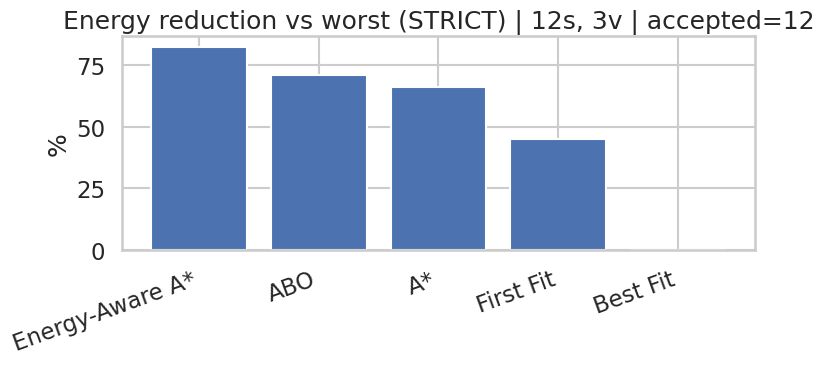

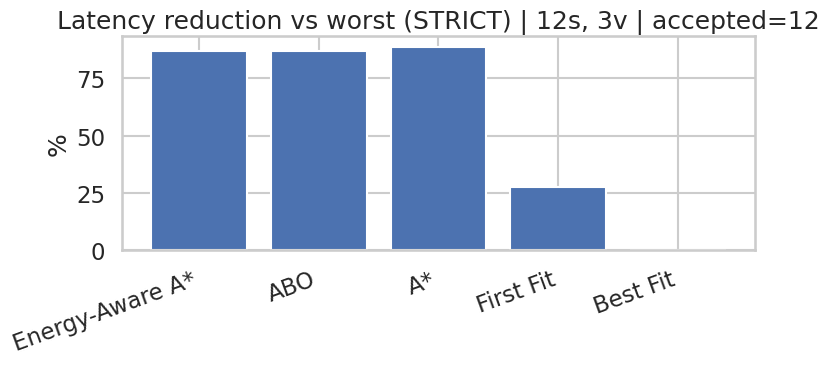

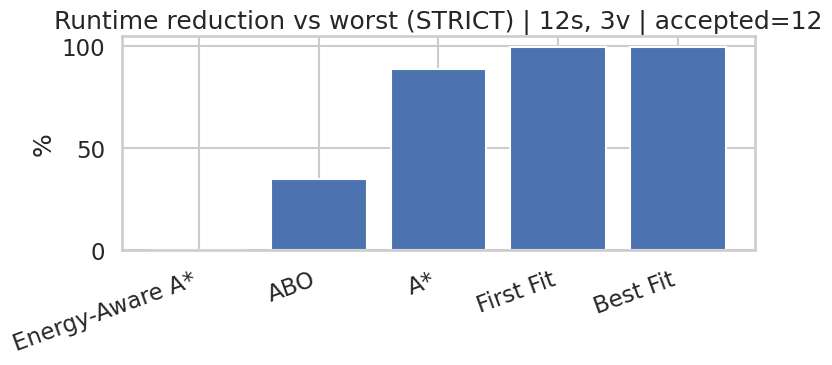

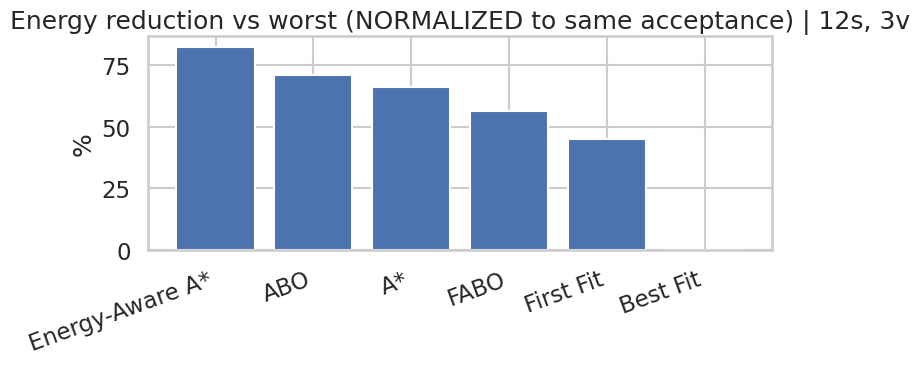

In [58]:
# --- Choose your scenario here ---
slices_target = 12
vnfs_target   = 3

strict_cmp, norm_cmp, max_acc = fair_percentages_for_scenario(
    df, slices_target, vnfs_target,
    baseline="A*", aggregate_over_seeds=True
)

print(f"[Scenario] {slices_target} slices, {vnfs_target} VNFs/slice | Max accepted = {max_acc}")

print("\n=== STRICT (only methods with max acceptance) ===")
display(strict_cmp[[
    "method","accepted","total_energy","total_latency","runtime_sec",
    "energy_per_accepted","latency_per_accepted",
    "gain_energy_vs_worst_%","gain_latency_vs_worst_%","gain_runtime_vs_worst_%",
    "gain_energy_vs_baseline_%","gain_latency_vs_baseline_%","gain_runtime_vs_baseline_%"
]])

print("\n=== NORMALIZED (all methods scaled to same acceptance) ===")
display(norm_cmp[[
    "method","accepted","acceptance_ratio_%","energy_per_accepted",
    "energy_norm_to_max_accept","gain_energy_norm_vs_worst_%",
    "total_latency","runtime_sec"
]])

# Quick plots
if not strict_cmp.empty:
    plot_percent_bars(strict_cmp, "gain_energy_vs_worst_%",
                      f"Energy reduction vs worst (STRICT) | {slices_target}s, {vnfs_target}v | accepted={max_acc}")
    plot_percent_bars(strict_cmp, "gain_latency_vs_worst_%",
                      f"Latency reduction vs worst (STRICT) | {slices_target}s, {vnfs_target}v | accepted={max_acc}")
    plot_percent_bars(strict_cmp, "gain_runtime_vs_worst_%",
                      f"Runtime reduction vs worst (STRICT) | {slices_target}s, {vnfs_target}v | accepted={max_acc}")

plot_percent_bars(norm_cmp, "gain_energy_norm_vs_worst_%",
                  f"Energy reduction vs worst (NORMALIZED to same acceptance) | {slices_target}s, {vnfs_target}v")


In [59]:
# --- Batch all scenarios: export STRICT and NORMALIZED summaries to CSVs ---

def batch_all_scenarios(df, baseline="A*", aggregate_over_seeds=True,
                        out_strict="summary_STRICT.csv", out_norm="summary_NORMALIZED.csv"):
    rows_strict, rows_norm = [], []
    for (slices_target, vnfs_target), d in df.groupby(["num_slices","num_vnfs_per_slice"]):
        try:
            strict_cmp, norm_cmp, max_acc = fair_percentages_for_scenario(
                df, slices_target, vnfs_target, baseline=baseline, aggregate_over_seeds=aggregate_over_seeds
            )
            if not strict_cmp.empty:
                sc = strict_cmp.copy()
                sc.insert(0, "num_vnfs_per_slice", vnfs_target)
                sc.insert(0, "num_slices", slices_target)
                sc.insert(2, "max_accepted_in_scenario", max_acc)
                rows_strict.append(sc)

            nc = norm_cmp.copy()
            nc.insert(0, "num_vnfs_per_slice", vnfs_target)
            nc.insert(0, "num_slices", slices_target)
            nc.insert(2, "max_accepted_in_scenario", max_acc)
            rows_norm.append(nc)
        except Exception as e:
            print(f"[WARN] Scenario ({slices_target}, {vnfs_target}) skipped: {e}")

    strict_all = pd.concat(rows_strict, ignore_index=True) if rows_strict else pd.DataFrame()
    norm_all   = pd.concat(rows_norm,   ignore_index=True) if rows_norm   else pd.DataFrame()

    if not strict_all.empty:
        strict_all.to_csv(out_strict, index=False)
        print(f"Saved STRICT summary to: {out_strict}")
    if not norm_all.empty:
        norm_all.to_csv(out_norm, index=False)
        print(f"Saved NORMALIZED summary to: {out_norm}")

    return strict_all, norm_all

strict_all, norm_all = batch_all_scenarios(
    df, baseline="A*", aggregate_over_seeds=True,
    out_strict="summary_preliminary_STRICT.csv",
    out_norm="summary_preliminary_NORMALIZED.csv"
)

display(strict_all.head(10))
display(norm_all.head(10))


Saved STRICT summary to: summary_preliminary_STRICT.csv
Saved NORMALIZED summary to: summary_preliminary_NORMALIZED.csv


num_slices  num_vnfs_per_slice  max_accepted_in_scenario           method  \
0           4                   2                         4  Energy-Aware A*   
1           4                   2                         4              ABO   
2           4                   2                         4               A*   
3           4                   2                         4        First Fit   
4           4                   2                         4         Best Fit   
5           4                   3                         4  Energy-Aware A*   
6           4                   3                         4              ABO   
7           4                   3                         4               A*   
8           4                   3                         4        First Fit   
9           4                   3                         4         Best Fit   

   total_energy  total_latency  runtime_sec  total_bandwidth  accepted  \
0      3.763506       5.598645     0.178020            160.0       4.0   
1      4.014057       8.054828     0.197445            160.0       4.0   
2      4.264057       4.027414     0.032832            160.0       4.0   
3     11.609731     164.164467     0.002433           1280.0       4.0   
4     19.609731     126.143911     0.001547           1280.0       4.0   
5      5.967262      24.902575     0.624763            360.0       4.0   
6      6.780939      13.653472     0.391011            360.0       4.0   
7      8.048510      13.653472     0.099638            560.0       4.0   
8     22.220829     244.264482     0.001925           2580.0       4.0   
9     22.231059     243.962250     0.002125           2700.0       4.0   

   energy_per_accepted  latency_per_accepted  accepted_round  \
0             0.940877              1.399661             4.0   
1             1.003514              2.013707             4.0   
2             1.066014              1.006853             4.0   
3             2.902433             41.041117             4.0   
4             4.902433             31.535978             4.0   
5             1.491815              6.225644             4.0   
6             1.695235              3.413368             4.0   
7             2.012127              3.413368             4.0   
8             5.555207             61.066121             4.0   
9             5.557765             60.990562             4.0   

   gain_energy_vs_worst_%  gain_latency_vs_worst_%  gain_runtime_vs_worst_%  \
0               80.807966                96.589612                 9.838011   
1               79.530282                95.093440                 0.000000   
2               78.255405                97.546720                83.371753   
3               40.796073                 0.000000                98.767728   
4                0.000000                23.160040                99.216321   
5               73.157997                89.805077                 0.000000   
6               69.497903                94.410373                37.414433   
7               63.796103                94.410373                84.051875   
8                0.046016                 0.000000                99.691885   
9                0.000000                 0.123732                99.659829   

   gain_energy_vs_baseline_%  gain_latency_vs_baseline_%  \
0                  11.738831                  -39.013401   
1                   5.862962                 -100.000000   
2                   0.000000                    0.000000   
3                -172.269624                -3976.175835   
4                -359.884398                -3032.131877   
5                  25.858802                  -82.390047   
6                  15.749135                    0.000000   
7                   0.000000                    0.000000   
8                -176.086255                -1689.028279   
9                -176.213357                -1686.814688   

   gain_runtime_vs_baseline_%  
0                 -442.221835  
1      

num_slices  num_vnfs_per_slice  max_accepted_in_scenario           method  \
0           4                   2                         4  Energy-Aware A*   
1           4                   2                         4              ABO   
2           4                   2                         4               A*   
3           4                   2                         4        First Fit   
4           4                   2                         4         Best Fit   
5           4                   2                         4             FABO   
6           4                   3                         4  Energy-Aware A*   
7           4                   3                         4              ABO   
8           4                   3                         4               A*   
9           4                   3                         4             FABO   

   total_energy  total_latency  runtime_sec  total_bandwidth  accepted  \
0      3.763506       5.598645     0.178020            160.0       4.0   
1      4.014057       8.054828     0.197445            160.0       4.0   
2      4.264057       4.027414     0.032832            160.0       4.0   
3     11.609731     164.164467     0.002433           1280.0       4.0   
4     19.609731     126.143911     0.001547           1280.0       4.0   
5      3.500000       4.027414     0.130634              0.0       0.0   
6      5.967262      24.902575     0.624763            360.0       4.0   
7      6.780939      13.653472     0.391011            360.0       4.0   
8      8.048510      13.653472     0.099638            560.0       4.0   
9      8.147498      10.854150     0.340493            260.0       2.0   

   energy_per_accepted  latency_per_accepted  accepted_round  \
0             0.940877              1.399661             4.0   
1             1.003514              2.013707             4.0   
2             1.066014              1.006853             4.0   
3             2.902433             41.041117             4.0   
4             4.902433             31.535978             4.0   
5                  NaN                   NaN             0.0   
6             1.491815              6.225644             4.0   
7             1.695235              3.413368             4.0   
8             2.012127              3.413368             4.0   
9             4.073749              5.427075             2.0   

   energy_norm_to_max_accept  gain_energy_norm_vs_worst_%  acceptance_ratio_%  \
0                   3.763506                    80.807966               100.0   
1                   4.014057                    79.530282               100.0   
2                   4.264057                    78.255405               100.0   
3                  11.609731                    40.796073               100.0   
4                  19.609731                     0.000000               100.0   
5                        inf                         -inf                 0.0   
6                   5.967262                    73.157997               100.0   
7                   6.780939                    69.497903               100.0   
8                   8.048510                    63.796103               100.0   
9                  16.294996                    26.701668                50.0   

   acceptance_gap  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5             4.0  
6             0.0  
7             0.0  
8             0.0  
9             2.0

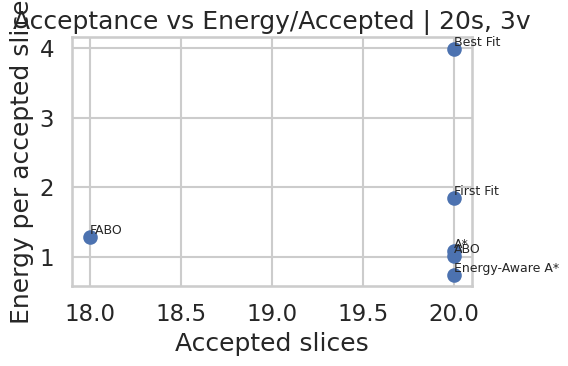

In [60]:
# --- Scatter: accepted vs energy per accepted, to reveal dominated methods ---
def scatter_acceptance_vs_energy(df, slices_target, vnfs_target, aggregate_over_seeds=True):
    d = df[(df["num_slices"]==slices_target) & (df["num_vnfs_per_slice"]==vnfs_target)].copy()
    d = _aggregate_scenario(d, aggregate_over_seeds=aggregate_over_seeds)

    plt.figure(figsize=(6,4))
    plt.scatter(d["accepted"], d["energy_per_accepted"])
    for _, r in d.iterrows():
        plt.text(r["accepted"], r["energy_per_accepted"], r["method"], fontsize=9, ha='left', va='bottom')
    plt.xlabel("Accepted slices")
    plt.ylabel("Energy per accepted slice")
    plt.title(f"Acceptance vs Energy/Accepted | {slices_target}s, {vnfs_target}v")
    plt.tight_layout()
    plt.show()

scatter_acceptance_vs_energy(df, slices_target=20, vnfs_target=3, aggregate_over_seeds=True)


In [61]:
# --- Imports and data loading (adjust the csv_path) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = "results/2025-11-12_15-33-38/load_scalability_results.csv"  # ajuste o caminho
df = pd.read_csv(csv_path)

# Quick sanity check
df.head()


timestamp  num_slices  num_vnfs_per_slice  seed     method  \
0  2025-11-12 15:34:52           4                   2     1         A*   
1  2025-11-12 15:34:52           4                   2     1        ABO   
2  2025-11-12 15:34:52           4                   2     1       FABO   
3  2025-11-12 15:34:52           4                   2     1   Best Fit   
4  2025-11-12 15:34:52           4                   2     1  First Fit   

   accepted  total_energy  total_bandwidth  total_latency  runtime_sec  
0         4      4.264057            160.0       4.027414     0.032832  
1         4      4.014057            160.0       8.054828     0.197445  
2         0      3.500000              0.0       4.027414     0.130634  
3         4     19.609731           1280.0     126.143911     0.001547  
4         4     11.609731           1280.0     164.164467     0.002433

In [62]:
# --- Basic cleaning and derived columns ---
# Ensure expected columns exist
expected_cols = {
    "timestamp", "num_slices", "num_vnfs_per_slice", "seed",
    "method", "accepted", "total_energy", "total_bandwidth", "total_latency", "runtime_sec"
}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Convert numeric columns just in case
num_cols = ["num_slices", "num_vnfs_per_slice", "seed", "accepted",
            "total_energy", "total_bandwidth", "total_latency", "runtime_sec"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Derived KPIs
df["energy_per_accepted"] = np.where(df["accepted"] > 0, df["total_energy"] / df["accepted"], np.nan)
df["latency_per_accepted"] = np.where(df["accepted"] > 0, df["total_latency"] / df["accepted"], np.nan)


In [63]:
# --- Function to compute percentage comparisons for a given scenario ---
def compare_percentages(df, slices_target, vnfs_target, aggregate_over_seeds=True, baseline="A*"):
    """
    Computes percentage gains (higher is better) for energy, latency, and runtime.
    - Gains are computed as reduction vs 'worst' (max) among methods for the scenario.
    - Also computes reduction vs 'baseline' (e.g., "A*") if present.
    - If aggregate_over_seeds=True, first aggregates per method by mean over seeds.
    Returns a summary DataFrame.
    """
    # Filter scenario
    d = df[(df["num_slices"] == slices_target) & (df["num_vnfs_per_slice"] == vnfs_target)].copy()
    if d.empty:
        raise ValueError("No rows found for the requested scenario.")

    # Aggregate over seeds if requested
    if aggregate_over_seeds:
        agg = (d.groupby("method", as_index=False)
                 .agg(total_energy=("total_energy", "mean"),
                      total_latency=("total_latency", "mean"),
                      runtime_sec=("runtime_sec", "mean"),
                      accepted=("accepted", "mean"),
                      energy_per_accepted=("energy_per_accepted", "mean"),
                      latency_per_accepted=("latency_per_accepted", "mean")))
    else:
        # Keep as-is (e.g., if you want per-seed lines). For clean comparison, still group by method.
        agg = (d.groupby(["method", "seed"], as_index=False)
                 .agg(total_energy=("total_energy", "mean"),
                      total_latency=("total_latency", "mean"),
                      runtime_sec=("runtime_sec", "mean"),
                      accepted=("accepted", "mean"),
                      energy_per_accepted=("energy_per_accepted", "mean"),
                      latency_per_accepted=("latency_per_accepted", "mean")))
    
    # For percentage gains, we want one row per method; if seed is present, pick mean again
    if "seed" in agg.columns:
        agg = (agg.groupby("method", as_index=False)
                 .mean(numeric_only=True))

    # Compute worst values (max -> since we measure reductions)
    worst_energy = agg["total_energy"].max()
    worst_latency = agg["total_latency"].max()
    worst_runtime = agg["runtime_sec"].max()

    # Gains vs worst (%): (worst - value) / worst * 100
    agg["gain_energy_vs_worst_%"] = (worst_energy - agg["total_energy"]) / worst_energy * 100.0
    agg["gain_latency_vs_worst_%"] = (worst_latency - agg["total_latency"]) / worst_latency * 100.0
    agg["gain_runtime_vs_worst_%"] = (worst_runtime - agg["runtime_sec"]) / worst_runtime * 100.0

    # Gains vs baseline (%): (baseline - value) / baseline * 100
    if baseline in agg["method"].values:
        b = agg.loc[agg["method"] == baseline].iloc[0]
        agg["gain_energy_vs_baseline_%"] = (b["total_energy"] - agg["total_energy"]) / b["total_energy"] * 100.0
        agg["gain_latency_vs_baseline_%"] = (b["total_latency"] - agg["total_latency"]) / b["total_latency"] * 100.0
        agg["gain_runtime_vs_baseline_%"] = (b["runtime_sec"] - agg["runtime_sec"]) / b["runtime_sec"] * 100.0
    else:
        agg["gain_energy_vs_baseline_%"] = np.nan
        agg["gain_latency_vs_baseline_%"] = np.nan
        agg["gain_runtime_vs_baseline_%"] = np.nan

    # Order by best energy gain vs worst (descending)
    agg = agg.sort_values(by="gain_energy_vs_worst_%", ascending=False).reset_index(drop=True)

    # Keep a compact set of columns
    keep = [
        "method", "accepted",
        "total_energy", "total_latency", "runtime_sec",
        "energy_per_accepted", "latency_per_accepted",
        "gain_energy_vs_worst_%", "gain_latency_vs_worst_%", "gain_runtime_vs_worst_%",
        "gain_energy_vs_baseline_%", "gain_latency_vs_baseline_%", "gain_runtime_vs_baseline_%"
    ]
    return agg[keep]


In [64]:
# --- Run a scenario comparison and export as CSV ---
slices_target = 20
vnfs_target = 3

summary = compare_percentages(df, slices_target, vnfs_target, aggregate_over_seeds=True, baseline="A*")
display(summary)

out_csv = f"summary_percentages_{slices_target}slices_{vnfs_target}vnfs.csv"
summary.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


method  accepted  total_energy  total_latency  runtime_sec  \
0  Energy-Aware A*      20.0     14.741371     160.970530     5.778383   
1              ABO      20.0     20.141919     170.589474     3.129368   
2               A*      20.0     21.623934     148.202834     0.471426   
3             FABO      18.0     22.946137     151.642488     2.766536   
4        First Fit      20.0     36.857551     615.799870     0.009704   
5         Best Fit      20.0     79.910639    1295.891725     0.011415   

   energy_per_accepted  latency_per_accepted  gain_energy_vs_worst_%  \
0             0.737069              8.048527               81.552680   
1             1.007096              8.529474               74.794447   
2             1.081197              7.410142               72.939856   
3             1.274785              8.424583               71.285254   
4             1.842878             30.789993               53.876540   
5             3.995532             64.794586                0.000000   

   gain_latency_vs_worst_%  gain_runtime_vs_worst_%  \
0                87.578397                 0.000000   
1                86.836132                45.843546   
2                88.563641                91.841555   
3                88.298213                52.122670   
4                52.480608                99.832058   
5                 0.000000                99.802449   

   gain_energy_vs_baseline_%  gain_latency_vs_baseline_%  \
0                  31.828449                   -8.615015   
1                   6.853587                  -15.105406   
2                   0.000000                    0.000000   
3                  -6.114536                   -2.320910   
4                 -70.447947                 -315.511535   
5                -269.547185                 -774.404147   

   gain_runtime_vs_baseline_%  
0                -1125.723750  
1                 -563.808517  
2                    0.000000  
3                 -486.843810  
4                   97.941491  
5                   97.578573

Saved: summary_percentages_20slices_3vnfs.csv


In [65]:
# --- Fair comparison utilities: acceptance-aware percentage analysis ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def aggregate_scenario(df, slices_target, vnfs_target, aggregate_over_seeds=True):
    """
    Aggregate rows for a fixed (num_slices, num_vnfs_per_slice) scenario.
    """
    d = df[(df["num_slices"] == slices_target) & (df["num_vnfs_per_slice"] == vnfs_target)].copy()
    if d.empty:
        raise ValueError("No rows for the requested scenario.")
        
    if aggregate_over_seeds:
        agg = (d.groupby("method", as_index=False)
                 .agg(total_energy=("total_energy", "mean"),
                      total_latency=("total_latency", "mean"),
                      runtime_sec=("runtime_sec", "mean"),
                      accepted=("accepted", "mean"),
                      total_bandwidth=("total_bandwidth","mean")))
    else:
        agg = d.copy()
    # Derive energy/latency per accepted
    agg["energy_per_accepted"]  = np.where(agg["accepted"]>0, agg["total_energy"]/agg["accepted"], np.nan)
    agg["latency_per_accepted"] = np.where(agg["accepted"]>0, agg["total_latency"]/agg["accepted"], np.nan)
    return agg


def fair_percentages(df, slices_target, vnfs_target, aggregate_over_seeds=True, baseline="A*"):
    """
    Acceptance-aware comparison in percentages.
    We provide TWO consistent views:

    View A (Strict): compare ONLY methods that achieved max acceptance in this scenario.
    View B (Normalized): for all methods, scale energy to hypothetical same acceptance (max_accepted),
                         assuming linear scaling w.r.t. accepted (conservative penalization).

    Returns:
      strict_cmp: methods with accepted == max_accepted (true apples-to-apples)
      norm_cmp: all methods with energy normalized to max_accepted
    """
    agg = aggregate_scenario(df, slices_target, vnfs_target, aggregate_over_seeds)
    # Round accepted if aggregated-over-seeds yields float very near an int
    agg["accepted_round"] = agg["accepted"].round(6)
    max_acc = agg["accepted_round"].max()

    # ------------- View A: Strict (only max acceptance) -------------
    strict = agg[agg["accepted_round"] == max_acc].copy()
    if not strict.empty:
        # Gains vs worst among strict set
        worst_E = strict["total_energy"].max()
        worst_L = strict["total_latency"].max()
        worst_T = strict["runtime_sec"].max()

        strict["gain_energy_vs_worst_%"]  = (worst_E - strict["total_energy"]) / worst_E * 100.0
        strict["gain_latency_vs_worst_%"] = (worst_L - strict["total_latency"]) / worst_L * 100.0
        strict["gain_runtime_vs_worst_%"] = (worst_T - strict["runtime_sec"]) / worst_T * 100.0

        # Optional: gains vs baseline if baseline is in strict set
        if baseline in strict["method"].values:
            b = strict.loc[strict["method"] == baseline].iloc[0]
            strict["gain_energy_vs_baseline_%"]  = (b["total_energy"]  - strict["total_energy"])  / b["total_energy"]  * 100.0
            strict["gain_latency_vs_baseline_%"] = (b["total_latency"] - strict["total_latency"]) / b["total_latency"] * 100.0
            strict["gain_runtime_vs_baseline_%"] = (b["runtime_sec"]   - strict["runtime_sec"])   / b["runtime_sec"]   * 100.0
        else:
            strict["gain_energy_vs_baseline_%"] = np.nan
            strict["gain_latency_vs_baseline_%"] = np.nan
            strict["gain_runtime_vs_baseline_%"] = np.nan

    # ------------- View B: Normalized to same acceptance -------------
    norm = agg.copy()
    # Linear normalization (conservative): energy at equal acceptance
    # If a method accepted less, we scale up its energy to match max_accepted.
    # If accepted == 0, set to +inf to strongly penalize.
    norm["energy_norm_to_max_accept"] = np.where(
        norm["accepted_round"] > 0,
        norm["total_energy"] * (max_acc / norm["accepted_round"]),
        np.inf
    )
    # Gains vs worst using normalized energy
    worst_E_norm = norm["energy_norm_to_max_accept"].replace([np.inf, -np.inf], np.nan).max()
    norm["gain_energy_norm_vs_worst_%"] = (worst_E_norm - norm["energy_norm_to_max_accept"]) / worst_E_norm * 100.0

    # Keep acceptance context
    norm["acceptance_ratio_%"] = (norm["accepted_round"] / max_acc) * 100.0
    norm["acceptance_gap"] = max_acc - norm["accepted_round"]

    # Order for readability
    strict = strict.sort_values(by="gain_energy_vs_worst_%", ascending=False) if not strict.empty else strict
    norm   = norm.sort_values(by="gain_energy_norm_vs_worst_%", ascending=False)

    return strict.reset_index(drop=True), norm.reset_index(drop=True), int(max_acc)


def plot_bars_percent(summary, col_percent, title):
    """Simple bar plot for percentage columns (one plot per metric)."""
    x = np.arange(len(summary))
    y = summary[col_percent].values
    labels = summary["method"].values

    plt.figure(figsize=(8, 4))
    plt.bar(x, y)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylabel("%")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [66]:
# --- Run fair analysis for a scenario ---
slices_target = 20
vnfs_target   = 3

strict_cmp, norm_cmp, max_acc = fair_percentages(
    df, slices_target, vnfs_target,
    aggregate_over_seeds=True, baseline="A*"
)

print(f"[Scenario] {slices_target} slices, {vnfs_target} VNFs/slice | Max accepted = {max_acc}")
print("\n=== View A: STRICT (only methods with max acceptance) ===")
display(strict_cmp[[
    "method", "accepted", "total_energy", "total_latency", "runtime_sec",
    "gain_energy_vs_worst_%", "gain_latency_vs_worst_%", "gain_runtime_vs_worst_%",
    "gain_energy_vs_baseline_%", "gain_latency_vs_baseline_%", "gain_runtime_vs_baseline_%"
]])

print("\n=== View B: NORMALIZED (all methods, energy scaled to same acceptance) ===")
display(norm_cmp[[
    "method", "accepted", "acceptance_ratio_%", "energy_per_accepted", "energy_norm_to_max_accept",
    "gain_energy_norm_vs_worst_%", "total_latency", "runtime_sec"
]])


[Scenario] 20 slices, 3 VNFs/slice | Max accepted = 20

=== View A: STRICT (only methods with max acceptance) ===


method  accepted  total_energy  total_latency  runtime_sec  \
0  Energy-Aware A*      20.0     14.741371     160.970530     5.778383   
1              ABO      20.0     20.141919     170.589474     3.129368   
2               A*      20.0     21.623934     148.202834     0.471426   
3        First Fit      20.0     36.857551     615.799870     0.009704   
4         Best Fit      20.0     79.910639    1295.891725     0.011415   

   gain_energy_vs_worst_%  gain_latency_vs_worst_%  gain_runtime_vs_worst_%  \
0               81.552680                87.578397                 0.000000   
1               74.794447                86.836132                45.843546   
2               72.939856                88.563641                91.841555   
3               53.876540                52.480608                99.832058   
4                0.000000                 0.000000                99.802449   

   gain_energy_vs_baseline_%  gain_latency_vs_baseline_%  \
0                  31.828449                   -8.615015   
1                   6.853587                  -15.105406   
2                   0.000000                    0.000000   
3                 -70.447947                 -315.511535   
4                -269.547185                 -774.404147   

   gain_runtime_vs_baseline_%  
0                -1125.723750  
1                 -563.808517  
2                    0.000000  
3                   97.941491  
4                   97.578573


=== View B: NORMALIZED (all methods, energy scaled to same acceptance) ===


method  accepted  acceptance_ratio_%  energy_per_accepted  \
0  Energy-Aware A*      20.0               100.0             0.737069   
1              ABO      20.0               100.0             1.007096   
2               A*      20.0               100.0             1.081197   
3             FABO      18.0                90.0             1.274785   
4        First Fit      20.0               100.0             1.842878   
5         Best Fit      20.0               100.0             3.995532   

   energy_norm_to_max_accept  gain_energy_norm_vs_worst_%  total_latency  \
0                  14.741371                    81.552680     160.970530   
1                  20.141919                    74.794447     170.589474   
2                  21.623934                    72.939856     148.202834   
3                  25.495708                    68.094727     151.642488   
4                  36.857551                    53.876540     615.799870   
5                  79.910639                     0.000000    1295.891725   

   runtime_sec  
0     5.778383  
1     3.129368  
2     0.471426  
3     2.766536  
4     0.009704  
5     0.011415

# Graphs Heuristics and MILP

In [71]:
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy

from milp.create_instance import create_instance
from milp.solver_gurobi import solve_gurobi
from utils.topology import topologie_finlande, topology_brazil
from milp.adapter import MILPResultAdapterGurobi

# --- Global MILP / experiment parameters ---
MILP_TIME_LIMIT = 300       # Time limit per MILP run (seconds)
ENTRY = 6                   # Fixed entry node
MAX_MILP_SLICES = 128       # Run MILP only if number of slices ≤ this
MAX_MILP_VNFS_TOTAL = 512   # Hard cap: total VNFs (num_slices × num_vnfs) ≤ this

# --- Topology ---
G = topologie_finlande()
ENTRY = 6

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid ---
param_grid = {
    "num_slices": [4, 6, 8, 10, 12, 16, 18, 20, 32],
    "num_vnfs_per_slice": [2, 3, 4],
    "seed": [1,2,3,4,5],
}

max_slices = max(param_grid["num_slices"])

# IMPORTANT: reset records before the main loop
records = []

# ------------------------------------------------------------------
# Main experiment loop with a fixed pool of slices per (vnf, seed)
# ------------------------------------------------------------------
for num_vnfs in param_grid["num_vnfs_per_slice"]:
    for seed in param_grid["seed"]:
        # Fix randomness once per (num_vnfs, seed)
        random.seed(seed)
        np.random.seed(seed)

        print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, VNFs={num_vnfs}, seed={seed} ===")

        # --- Generate a fixed pool of slices for this (num_vnfs, seed) ---
        slice_pool = generate_random_slices(
            G,
            vnf_profiles,
            num_slices=max_slices,
            num_vnfs_per_slice=num_vnfs,
            entry=ENTRY
        )

        # Sanity check (optional)
        if len(slice_pool) < max_slices:
            print(f"[WARN] slice_pool has only {len(slice_pool)} entries (expected {max_slices}).")

        # Now sweep num_slices by taking prefixes of the same pool
        for num_slices in param_grid["num_slices"]:
            total_vnfs = num_slices * num_vnfs

            print(f"\n[INFO] === Running Load Test: {num_slices} slices × {num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

            # Use the first num_slices from the fixed pool
            # deepcopy avoids unintended side-effects if algorithms modify slice objects
            slices = deepcopy(slice_pool[:num_slices])

            method_results = {}
            method_times = {}

            # --- Heuristics ---
            for name, func, args in [
                ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("Energy-Aware A*", energy_aware_astar,
                 (G, slices, node_capacity_base, link_capacity_base, 0.6, 0.4)),
            ]:
                start = time.time()
                try:
                    df_res, res_list = func(*args)
                    method_results[name] = res_list
                except Exception as e:
                    print(f"[ERROR] {name} failed: {e}")
                    method_results[name] = []
                method_times[name] = time.time() - start

            # --- MILP (only for small scenarios) ---
            if num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
                try:
                    print(f"\n[INFO][MILP] Running Gurobi MILP for {num_slices} slices ({total_vnfs} VNFs, limit {MILP_TIME_LIMIT}s)...")
                    start = time.time()

                    instance = create_instance(G, slices)
                    instance.entry_node = ENTRY

                    res = solve_gurobi(instance, msg=False, time_limit=MILP_TIME_LIMIT)
                    milp_adapter = MILPResultAdapterGurobi(res, instance)

                    method_results["MILP (Gurobi)"] = [milp_adapter]
                    method_times["MILP (Gurobi)"] = time.time() - start

                    print(f"[INFO][MILP] Completed in {method_times['MILP (Gurobi)']:.1f}s (status={res.status_str})")

                except Exception as e:
                    print(f"[ERROR][MILP] Failed: {e}")
                    method_results["MILP (Gurobi)"] = []
                    method_times["MILP (Gurobi)"] = None

            else:
                print(f"[SKIP][MILP] Skipped: {num_slices} slices × {num_vnfs} VNFs "
                      f"(total={total_vnfs}) exceeds limit ({MAX_MILP_SLICES} slices or {MAX_MILP_VNFS_TOTAL} VNFs).")

            # --- Compute metrics for all methods in this scenario ---
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })

# --- Save results ---
df_results = pd.DataFrame(records)

# Optional: safety check to ensure no duplicated (method, scenario)
dup = (df_results
       .groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"])
       .size()
       .reset_index(name="count"))
max_count = dup["count"].max()
print(f"[CHECK] Max repetitions of any (method, scenario) = {max_count}")
if max_count > 1:
    print("[WARN] There are duplicated scenarios in df_results!")
else:
    print("[OK] No duplicated scenarios per (method, num_slices, num_vnfs_per_slice, seed).")

output_path = os.path.join(results_dir, "scalability_results.csv")
df_results.to_csv(output_path, index=False)
print(f"\n[INFO] Results saved to {output_path}")




[INFO] === Pre-generating slice pool: max_slices=32, VNFs=2, seed=1 ===

[INFO] === Running Load Test: 4 slices × 2 VNFs (total=8), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][ABO] === Solving slice 1 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 1 accepted. min_node_cpu=14, links_low_bw=0

[INFO][ABO] === Solving slice 2 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 2 accepted. min_node_cpu=12, links

In [72]:
df_results.head()

timestamp  num_slices  num_vnfs_per_slice  total_vnfs  seed  \
0  2025-11-17 14:47:57           4                   2           8     1   
1  2025-11-17 14:47:57           4                   2           8     1   
2  2025-11-17 14:47:57           4                   2           8     1   
3  2025-11-17 14:47:57           4                   2           8     1   
4  2025-11-17 14:47:57           4                   2           8     1   

      method  accepted  total_energy  total_bandwidth  total_latency  \
0         A*         4        8.4450            160.0            4.0   
1        ABO         4        3.9100            160.0            8.0   
2       FABO         4       10.1775            160.0            8.0   
3   Best Fit         4        4.4450            160.0            4.0   
4  First Fit         4        4.2850            160.0           12.0   

   runtime_sec  
0     0.043261  
1     1.764038  
2     1.766809  
3     0.006718  
4     0.001228

In [73]:
import pandas as pd

df = pd.read_csv("results/2025-11-17_10-38-38/scalability_results.csv")
print(df.shape)
print(df.columns)
df.head(7)


(231, 11)
Index(['timestamp', 'num_slices', 'num_vnfs_per_slice', 'total_vnfs', 'seed',
       'method', 'accepted', 'total_energy', 'total_bandwidth',
       'total_latency', 'runtime_sec'],
      dtype='object')


timestamp  num_slices  num_vnfs_per_slice  total_vnfs  seed  \
0  2025-11-17 13:22:31           4                   2           8     1   
1  2025-11-17 13:22:31           4                   2           8     1   
2  2025-11-17 13:22:31           4                   2           8     1   
3  2025-11-17 13:22:31           4                   2           8     1   
4  2025-11-17 13:22:31           4                   2           8     1   
5  2025-11-17 13:22:31           4                   2           8     1   
6  2025-11-17 13:22:31           4                   2           8     1   

            method  accepted  total_energy  total_bandwidth  total_latency  \
0               A*         4        8.4450            160.0            4.0   
1              ABO         4        3.9100            160.0            8.0   
2             FABO         4       10.1775            160.0            8.0   
3         Best Fit         4        4.4450            160.0            4.0   
4        First Fit         4        4.2850            160.0           12.0   
5  Energy-Aware A*         4        8.4450            160.0            4.0   
6    MILP (Gurobi)         4        4.4450             40.0            4.0   

   runtime_sec  
0     0.162790  
1     1.897179  
2     1.785317  
3     0.006384  
4     0.001990  
5     0.062505  
6     0.141988

In [59]:
print(df.columns.tolist())


['timestamp', 'num_slices', 'num_vnfs_per_slice', 'total_vnfs', 'seed', 'method', 'accepted', 'total_energy', 'total_bandwidth', 'total_latency', 'runtime_sec']


In [74]:
# Quick check (diagnostics)
print("Methods in this CSV:", sorted(df["method"].astype(str).unique()))
print("Any MILP rows?", df["method"].astype(str).str.contains("MILP (Gurobi)", case=False, na=False).any())

# If there are near-misses (e.g., 'MILP ', 'milp_gurobi', 'MILP (TL)'):
milp_like = df[df["method"].astype(str).str.contains("MILP (Gurobi)", case=False, na=False)]
print("MILP-like rows:", len(milp_like))
milp_like.head()


Methods in this CSV: ['A*', 'ABO', 'Best Fit', 'Energy-Aware A*', 'FABO', 'First Fit', 'MILP (Gurobi)']
Any MILP rows? False
MILP-like rows: 0


/tmp/ipykernel_195157/1680761658.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print("Any MILP rows?", df["method"].astype(str).str.contains("MILP (Gurobi)", case=False, na=False).any())
/tmp/ipykernel_195157/1680761658.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  milp_like = df[df["method"].astype(str).str.contains("MILP (Gurobi)", case=False, na=False)]


Empty DataFrame
Columns: [timestamp, num_slices, num_vnfs_per_slice, total_vnfs, seed, method, accepted, total_energy, total_bandwidth, total_latency, runtime_sec]
Index: []

In [75]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="paper")

results_dir = globals().get("results_dir", "./results")
os.makedirs(results_dir, exist_ok=True)

df = pd.read_csv(os.path.join(results_dir, "scalability_results.csv"))

# --- Derived metrics (energy/latency normalized by accepted) ---
df["accept_rate"] = df["accepted"] / df["num_slices"]

df["energy_per_accepted"] = np.where(
    df["accepted"] > 0,
    df["total_energy"] / df["accepted"],
    np.nan
)

df["latency_per_accepted"] = np.where(
    df["accepted"] > 0,
    df["total_latency"] / df["accepted"],
    np.nan
)

df["bw_per_accepted"] = np.where(
    df["accepted"] > 0,
    df["total_bandwidth"] / df["accepted"],
    np.nan
)


In [76]:
# --- MILP baseline per scenario (num_slices, num_vnfs, seed) ---
milp = df[df["method"] == "MILP (Gurobi)"].copy()
milp = milp.rename(columns={
    "total_energy": "milp_energy",
    "total_latency": "milp_latency",
    "runtime_sec": "milp_runtime",
    "accepted": "milp_accepted",
})
milp = milp[[
    "num_slices", "num_vnfs_per_slice", "seed",
    "milp_energy", "milp_latency", "milp_runtime", "milp_accepted"
]]

# --- Merge MILP baseline with all methods on same scenario ---
df_merged = df.merge(
    milp,
    on=["num_slices", "num_vnfs_per_slice", "seed"],
    how="left"
)

# Relative gaps (%), where MILP exists and accepted > 0
df_merged["energy_gap_pct"] = np.where(
    (df_merged["milp_energy"] > 0) & (df_merged["accepted"] > 0),
    (df_merged["total_energy"] - df_merged["milp_energy"])
    / df_merged["milp_energy"] * 100,
    np.nan
)

df_merged["latency_gap_pct"] = np.where(
    (df_merged["milp_latency"] > 0) & (df_merged["accepted"] > 0),
    (df_merged["total_latency"] - df_merged["milp_latency"])
    / df_merged["milp_latency"] * 100,
    np.nan
)

df_merged["speedup_vs_milp"] = np.where(
    (df_merged["milp_runtime"] > 0) & (df_merged["runtime_sec"] > 0),
    df_merged["milp_runtime"] / df_merged["runtime_sec"],
    np.nan
)


In [77]:
# Example: aggregate over seeds (for now you only have seed=1, mas já fica pronto)
group_cols = ["num_slices", "num_vnfs_per_slice", "method"]

summary = (df_merged
           .groupby(group_cols, as_index=False)
           .agg(
               accept_rate_mean=("accept_rate", "mean"),
               accept_rate_std=("accept_rate", "std"),
               energy_per_acc_mean=("energy_per_accepted", "mean"),
               energy_per_acc_std=("energy_per_accepted", "std"),
               latency_per_acc_mean=("latency_per_accepted", "mean"),
               runtime_mean=("runtime_sec", "mean"),
               runtime_std=("runtime_sec", "std"),
               energy_gap_mean=("energy_gap_pct", "mean"),
               speedup_mean=("speedup_vs_milp", "mean"),
           ))

# Para uma tabelinha LaTeX enxuta (por exemplo, só num_vnfs_per_slice = 3)
tab = summary[summary["num_vnfs_per_slice"] == 3]

latex_table = tab.to_latex(index=False, float_format="%.2f")
print(latex_table)


\begin{tabular}{rrlrrrrrrrrr}
\toprule
num_slices & num_vnfs_per_slice & method & accept_rate_mean & accept_rate_std & energy_per_acc_mean & energy_per_acc_std & latency_per_acc_mean & runtime_mean & runtime_std & energy_gap_mean & speedup_mean \\
\midrule
4 & 3 & A* & 1.00 & 0.00 & 3.92 & 0.00 & 2.00 & 0.09 & 0.01 & 88.04 & 0.23 \\
4 & 3 & ABO & 1.00 & 0.00 & 3.84 & 0.00 & 3.00 & 7.73 & 0.27 & 83.99 & 0.00 \\
4 & 3 & Best Fit & 1.00 & 0.00 & 1.76 & 0.00 & 2.00 & 0.01 & 0.00 & -15.83 & 1.44 \\
4 & 3 & Energy-Aware A* & 1.00 & 0.00 & 3.92 & 0.00 & 2.00 & 0.27 & 0.01 & 88.04 & 0.07 \\
4 & 3 & FABO & 1.00 & 0.00 & 3.79 & 0.00 & 3.00 & 7.60 & 0.41 & 81.74 & 0.00 \\
4 & 3 & First Fit & 1.00 & 0.00 & 2.87 & 0.00 & 4.50 & 0.01 & 0.00 & 37.71 & 3.47 \\
4 & 3 & MILP (Gurobi) & 1.00 & 0.00 & 2.08 & 0.00 & 3.00 & 0.02 & 0.00 & 0.00 & 1.00 \\
6 & 3 & A* & 1.00 & 0.00 & 3.22 & 0.00 & 2.00 & 0.13 & 0.01 & 82.99 & 0.30 \\
6 & 3 & ABO & 1.00 & 0.00 & 2.84 & 0.00 & 3.00 & 11.88 & 0.42 & 61.30 & 0.00 \\

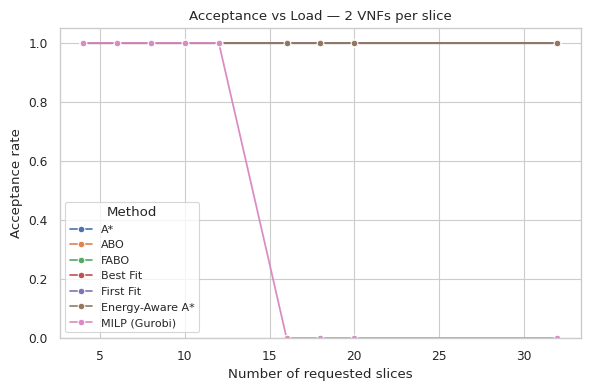

[INFO] Saved results/2025-11-17_14-47-02/acceptance_vs_load_vnf2.pdf


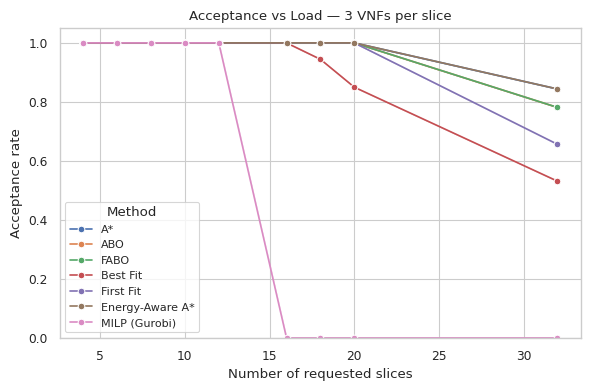

[INFO] Saved results/2025-11-17_14-47-02/acceptance_vs_load_vnf3.pdf


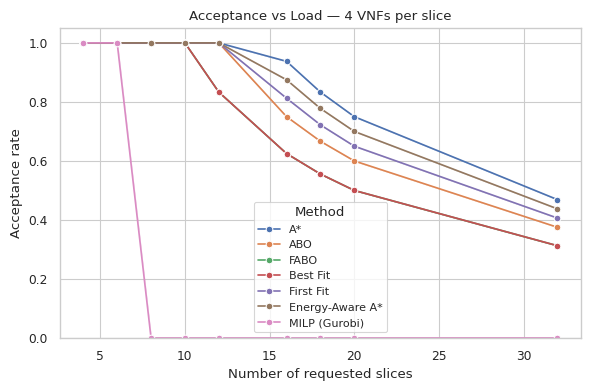

[INFO] Saved results/2025-11-17_14-47-02/acceptance_vs_load_vnf4.pdf


In [78]:
sns.set_theme(style="whitegrid", context="paper")

for vnf in sorted(df_merged["num_vnfs_per_slice"].unique()):
    d = df_merged[df_merged["num_vnfs_per_slice"] == vnf]

    plt.figure(figsize=(6,4))
    sns.lineplot(
        data=d,
        x="num_slices",
        y="accept_rate",
        hue="method",
        marker="o"
    )
    plt.ylim(0, 1.05)
    plt.xlabel("Number of requested slices")
    plt.ylabel("Acceptance rate")
    plt.title(f"Acceptance vs Load — {vnf} VNFs per slice")
    plt.legend(title="Method", fontsize=8)
    plt.tight_layout()

    path = os.path.join(results_dir, f"acceptance_vs_load_vnf{vnf}.pdf")
    plt.savefig(path)
    plt.show()
    print("[INFO] Saved", path)


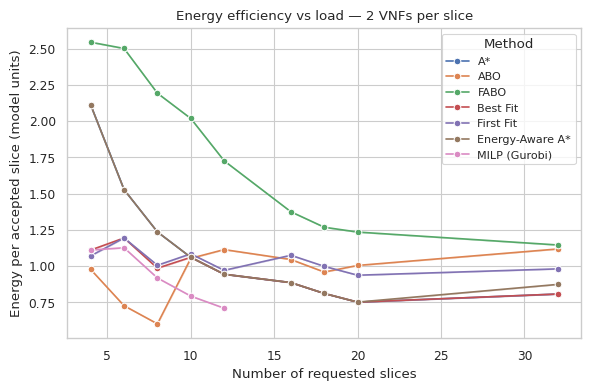

[INFO] Saved results/2025-11-17_14-47-02/energy_per_acc_vs_load_vnf2.pdf


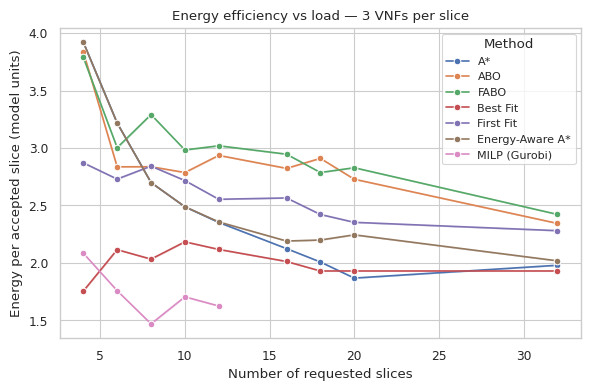

[INFO] Saved results/2025-11-17_14-47-02/energy_per_acc_vs_load_vnf3.pdf


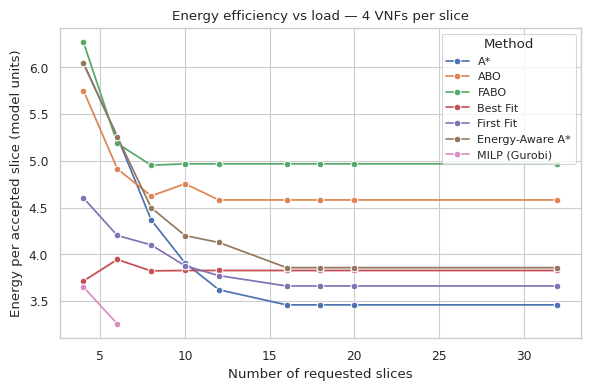

[INFO] Saved results/2025-11-17_14-47-02/energy_per_acc_vs_load_vnf4.pdf


In [79]:
for vnf in sorted(df_merged["num_vnfs_per_slice"].unique()):
    d = df_merged[df_merged["num_vnfs_per_slice"] == vnf]

    plt.figure(figsize=(6,4))
    sns.lineplot(
        data=d,
        x="num_slices",
        y="energy_per_accepted",
        hue="method",
        marker="o"
    )
    plt.xlabel("Number of requested slices")
    plt.ylabel("Energy per accepted slice (model units)")
    plt.title(f"Energy efficiency vs load — {vnf} VNFs per slice")
    plt.legend(title="Method", fontsize=8)
    plt.tight_layout()

    path = os.path.join(results_dir, f"energy_per_acc_vs_load_vnf{vnf}.pdf")
    plt.savefig(path)
    plt.show()
    print("[INFO] Saved", path)


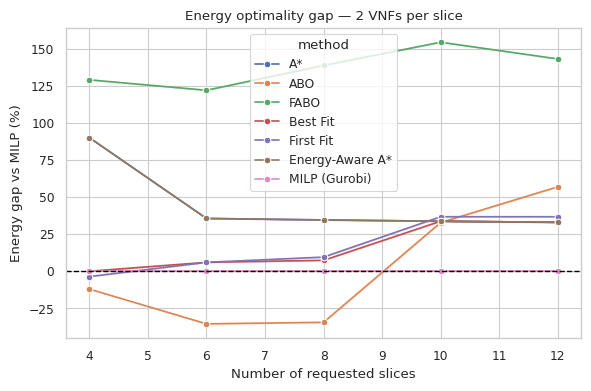

[INFO] Saved results/2025-11-17_14-47-02/energy_gap_vs_milp_vnf2.pdf


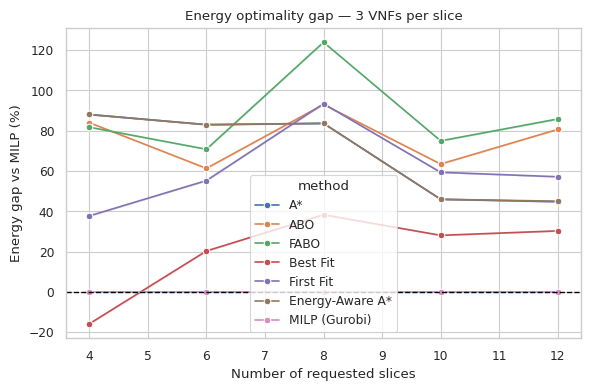

[INFO] Saved results/2025-11-17_14-47-02/energy_gap_vs_milp_vnf3.pdf


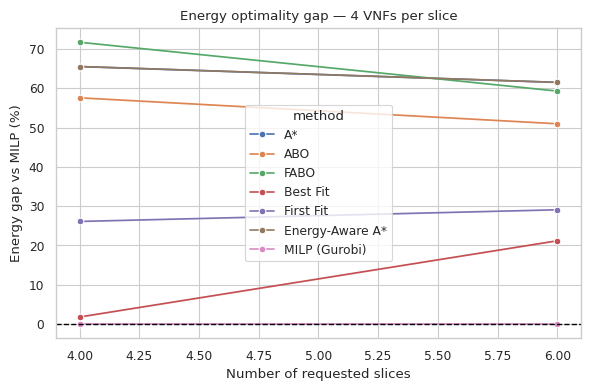

[INFO] Saved results/2025-11-17_14-47-02/energy_gap_vs_milp_vnf4.pdf


In [80]:
for vnf in sorted(df_merged["num_vnfs_per_slice"].unique()):
    d = df_merged[
        (df_merged["num_vnfs_per_slice"] == vnf) &
        df_merged["energy_gap_pct"].notna()
    ]

    if d.empty:
        continue

    plt.figure(figsize=(6,4))
    sns.lineplot(
        data=d,
        x="num_slices",
        y="energy_gap_pct",
        hue="method",
        marker="o"
    )
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("Number of requested slices")
    plt.ylabel("Energy gap vs MILP (%)")
    plt.title(f"Energy optimality gap — {vnf} VNFs per slice")
    plt.tight_layout()

    path = os.path.join(results_dir, f"energy_gap_vs_milp_vnf{vnf}.pdf")
    plt.savefig(path)
    plt.show()
    print("[INFO] Saved", path)


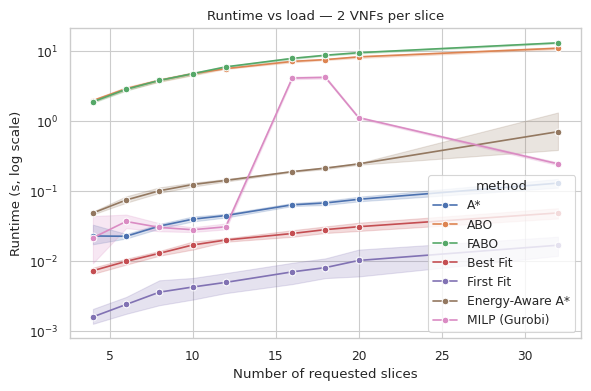

[INFO] Saved results/2025-11-17_14-47-02/runtime_vs_load_vnf2.pdf


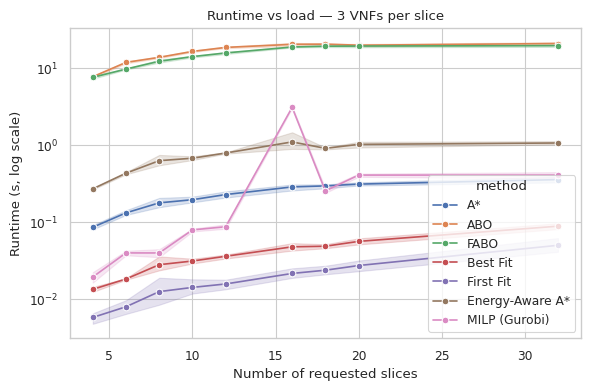

[INFO] Saved results/2025-11-17_14-47-02/runtime_vs_load_vnf3.pdf


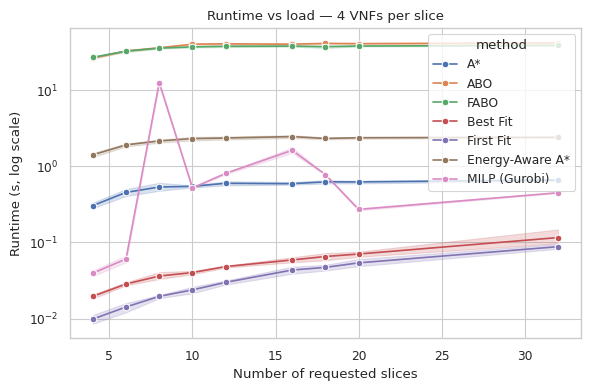

[INFO] Saved results/2025-11-17_14-47-02/runtime_vs_load_vnf4.pdf


In [81]:
for vnf in sorted(df_merged["num_vnfs_per_slice"].unique()):
    d = df_merged[df_merged["num_vnfs_per_slice"] == vnf]

    plt.figure(figsize=(6,4))
    sns.lineplot(
        data=d,
        x="num_slices",
        y="runtime_sec",
        hue="method",
        marker="o"
    )
    plt.yscale("log")  # runtime almost always em escala log
    plt.xlabel("Number of requested slices")
    plt.ylabel("Runtime (s, log scale)")
    plt.title(f"Runtime vs load — {vnf} VNFs per slice")
    plt.tight_layout()

    path = os.path.join(results_dir, f"runtime_vs_load_vnf{vnf}.pdf")
    plt.savefig(path)
    plt.show()
    print("[INFO] Saved", path)


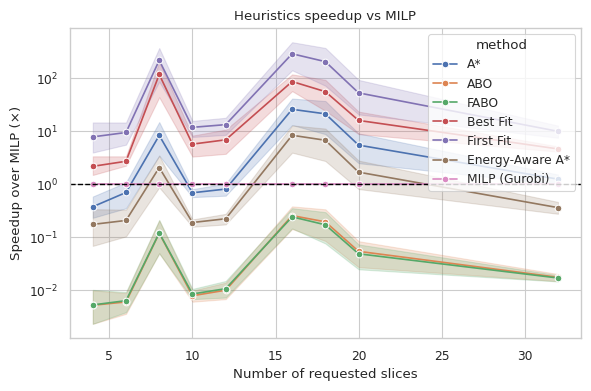

In [82]:
d = df_merged[df_merged["speedup_vs_milp"].notna()]
plt.figure(figsize=(6,4))
sns.lineplot(
    data=d,
    x="num_slices",
    y="speedup_vs_milp",
    hue="method",
    marker="o"
)
plt.yscale("log")
plt.axhline(1, color="black", linestyle="--", linewidth=1)
plt.xlabel("Number of requested slices")
plt.ylabel("Speedup over MILP (×)")
plt.title("Heuristics speedup vs MILP")
plt.tight_layout()
plt.show()


In [68]:
# --- Keep all rows, avoid division by zero, keep MILP visible ---
import numpy as np

df = df.copy()

# Compute safely; keep NaN when accepted == 0 (so we don't drop the row)
df["energy_per_accepted"] = np.where(
    df["accepted"] > 0,
    df["total_energy"] / df["accepted"],
    np.nan
)

# Optional tag for readability
df["no_solution"] = (df["accepted"] <= 0)  # True for MILP rows that failed after 12 slices



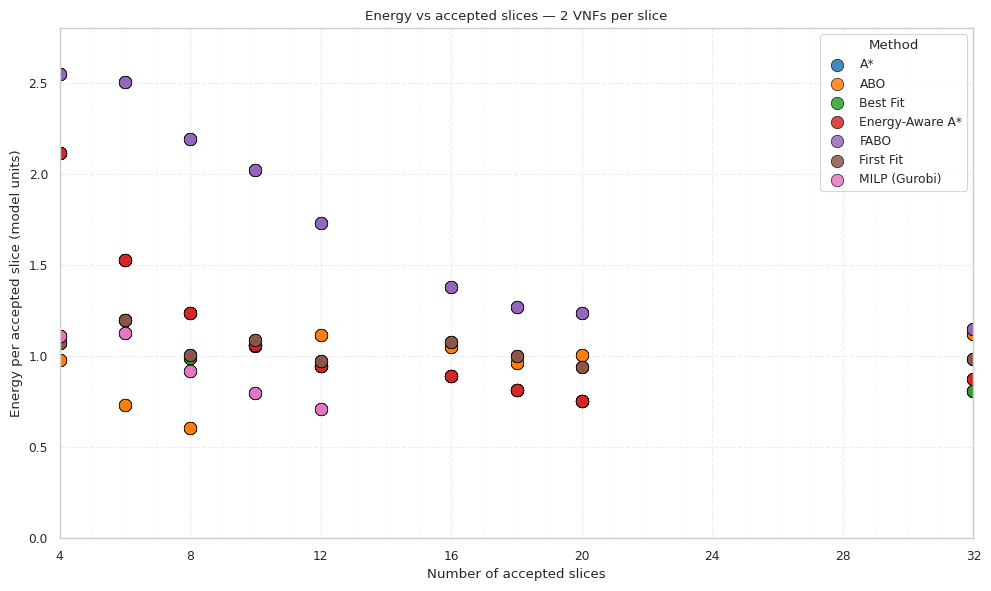

[INFO] Saved: results/2025-11-17_14-47-02/energy_vs_accepted_vnf2.png
[INFO] Saved: results/2025-11-17_14-47-02/energy_vs_accepted_vnf2.pdf


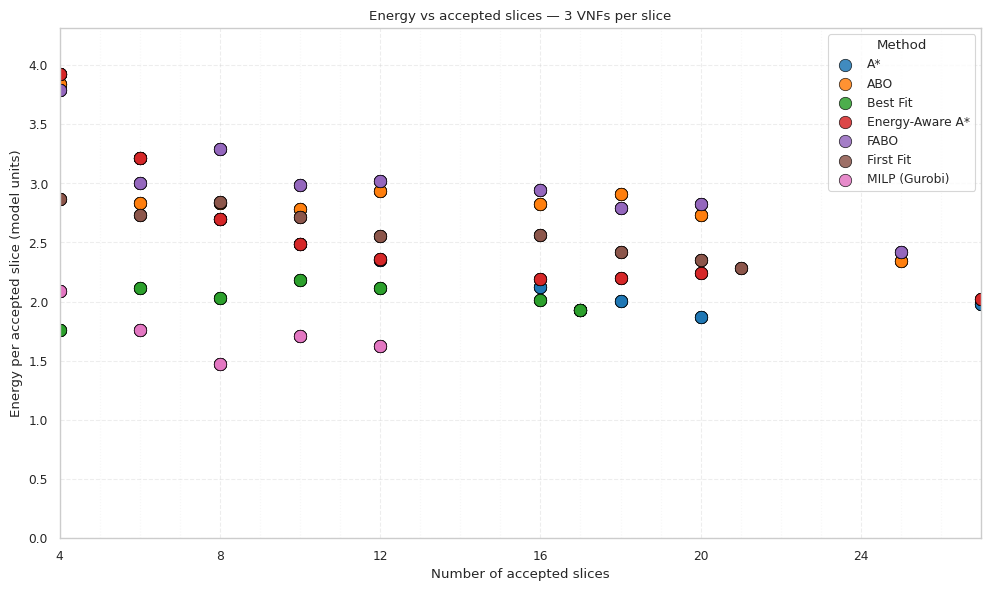

[INFO] Saved: results/2025-11-17_14-47-02/energy_vs_accepted_vnf3.png
[INFO] Saved: results/2025-11-17_14-47-02/energy_vs_accepted_vnf3.pdf


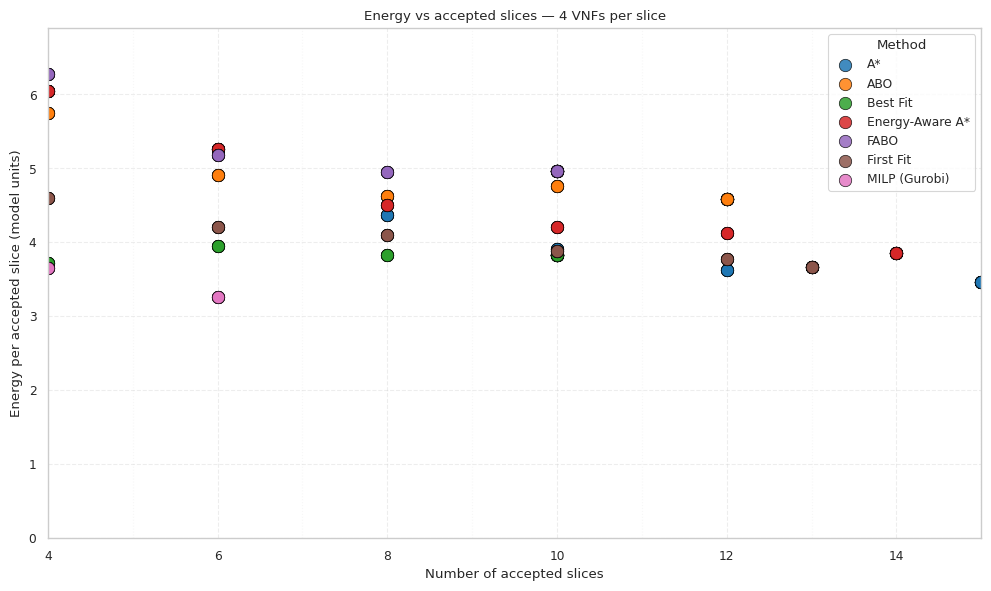

[INFO] Saved: results/2025-11-17_14-47-02/energy_vs_accepted_vnf4.png
[INFO] Saved: results/2025-11-17_14-47-02/energy_vs_accepted_vnf4.pdf


In [83]:
# --- Scatter plots: energy per accepted slice as a function of accepted slices ---
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Configure your output directory here
results_dir = globals().get("results_dir", "./results")
os.makedirs(results_dir, exist_ok=True)

df_plot = df.copy()

# Safe division (preserve rows with accepted == 0; y will be NaN)
df_plot["energy_per_accepted"] = np.where(
    df_plot["accepted"] > 0,
    df_plot["total_energy"] / df_plot["accepted"],
    np.nan
)

# Unique VNF-per-slice values
vnf_values = sorted(df_plot["num_vnfs_per_slice"].dropna().unique())

# Consistent color cycle across plots
color_cycle = plt.cm.tab10.colors

for vnf in vnf_values:
    d = df_plot[df_plot["num_vnfs_per_slice"] == vnf].copy()
    if d.empty:
        continue

    # Keep only rows with accepted > 0 (x-axis makes no sense for 0)
    d = d[d["accepted"] > 0].copy()
    if d.empty:
        continue

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each method separately for better legend
    methods = sorted(d["method"].dropna().unique())
    for i, m in enumerate(methods):
        sub = d[d["method"] == m]
        if sub.empty:
            continue
        ax.scatter(
            sub["accepted"],                # X = number of accepted slices
            sub["energy_per_accepted"],     # Y = energy per accepted slice
            s=80, alpha=0.85,
            edgecolors="black", linewidths=0.5,
            color=color_cycle[i % len(color_cycle)],
            label=m
        )

    # --- X axis: integer domain based on accepted slices ---
    if not d.empty:
        x_vals = sorted(d["accepted"].unique())
        x_min = int(min(x_vals))
        x_max = int(max(x_vals))
        ax.set_xlim(left=x_min, right=x_max)
        ax.margins(x=0.07)  # small padding

        span = max(1, x_max - x_min)
        if   span <= 10:
            major_step = 1
        elif span <= 20:
            major_step = 2
        else:
            major_step = 4

        ax.xaxis.set_major_locator(MultipleLocator(major_step))
        ax.xaxis.set_minor_locator(MultipleLocator(1))

    # --- Y axis: start at zero and auto upper bound ---
    all_y = d["energy_per_accepted"].values
    if len(all_y) and np.isfinite(np.nanmax(all_y)):
        y_top = np.nanmax(all_y) * 1.1
    else:
        y_top = 1.0
    ax.set_ylim(bottom=0, top=y_top)

    # Labels and title
    ax.set_xlabel("Number of accepted slices")
    ax.set_ylabel("Energy per accepted slice (model units)")
    ax.set_title(f"Energy vs accepted slices — {vnf} VNFs per slice")

    # Grid: stronger for major, lighter for minor
    ax.grid(True, which="major", linestyle="--", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":",  alpha=0.15)

    # Legend
    ax.legend(title="Method", frameon=True)

    fig.tight_layout()

    # Save figures
    base = f"energy_vs_accepted_vnf{vnf}"
    png_path = os.path.join(results_dir, f"{base}.png")
    pdf_path = os.path.join(results_dir, f"{base}.pdf")
    fig.savefig(png_path, dpi=300)
    fig.savefig(pdf_path)
    plt.show()

    print(f"[INFO] Saved: {png_path}")
    print(f"[INFO] Saved: {pdf_path}")


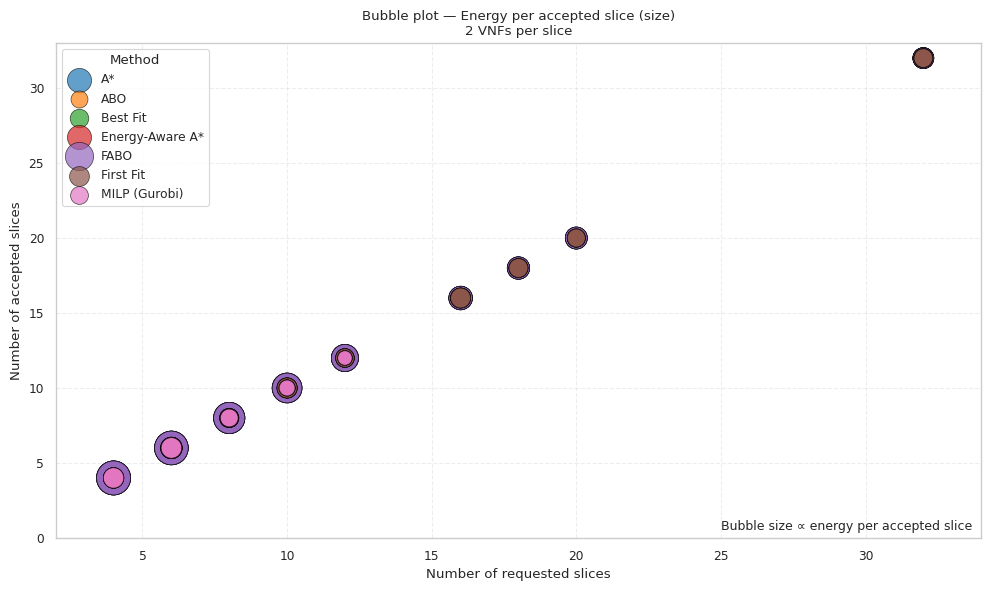

[INFO] Saved: results/2025-11-17_14-47-02/bubble_demand_vs_accept_energy_vnf2.png
[INFO] Saved: results/2025-11-17_14-47-02/bubble_demand_vs_accept_energy_vnf2.pdf


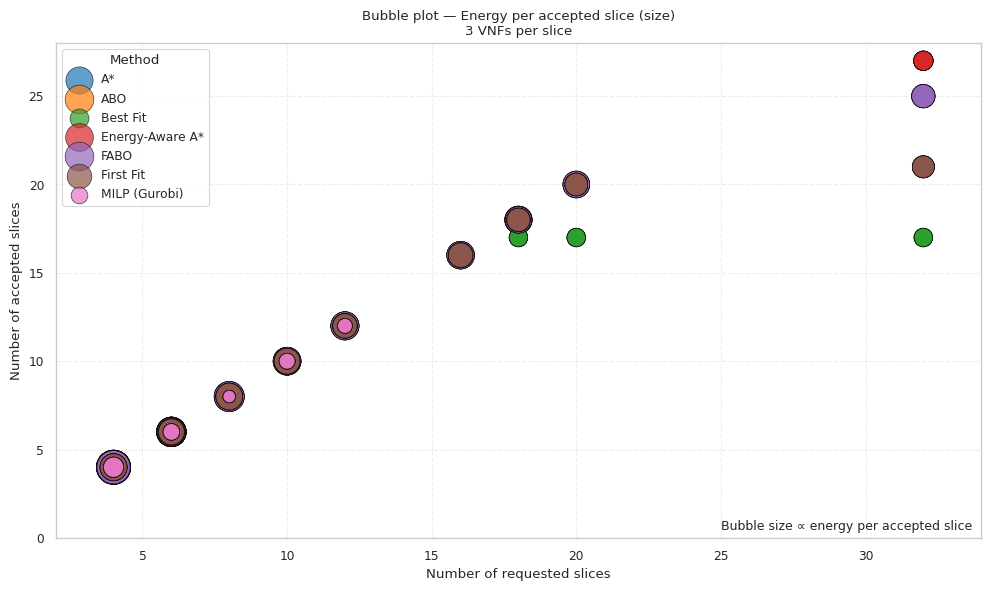

[INFO] Saved: results/2025-11-17_14-47-02/bubble_demand_vs_accept_energy_vnf3.png
[INFO] Saved: results/2025-11-17_14-47-02/bubble_demand_vs_accept_energy_vnf3.pdf


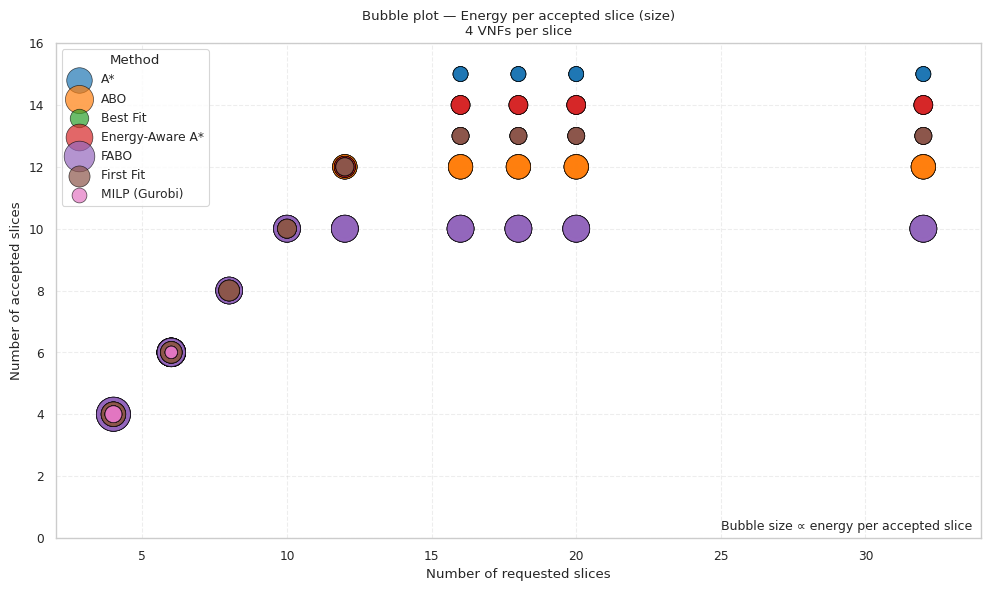

[INFO] Saved: results/2025-11-17_14-47-02/bubble_demand_vs_accept_energy_vnf4.png
[INFO] Saved: results/2025-11-17_14-47-02/bubble_demand_vs_accept_energy_vnf4.pdf


In [84]:
# Bubble plots: X = demanded slices, Y = accepted slices, size = energy per accepted slice
import os
import numpy as np
import matplotlib.pyplot as plt

# Ensure results_dir exists
results_dir = globals().get("results_dir", "./results")
os.makedirs(results_dir, exist_ok=True)

df_bubble = df.copy()

# Derived metric: energy per accepted slice
df_bubble["energy_per_accepted"] = np.where(
    df_bubble["accepted"] > 0,
    df_bubble["total_energy"] / df_bubble["accepted"],
    np.nan
)

# Keep only rows where it makes sense (accepted > 0 and finite energy_per_accepted)
df_bubble = df_bubble[
    (df_bubble["accepted"] > 0) &
    df_bubble["energy_per_accepted"].notna()
].copy()

# Unique VNF-per-slice values
vnf_values = sorted(df_bubble["num_vnfs_per_slice"].dropna().unique())
methods = sorted(df_bubble["method"].dropna().unique())

# Color mapping per method
color_cycle = plt.cm.tab10.colors
method_to_color = {m: color_cycle[i % len(color_cycle)] for i, m in enumerate(methods)}

for vnf in vnf_values:
    d = df_bubble[df_bubble["num_vnfs_per_slice"] == vnf].copy()
    if d.empty:
        continue

    # Normalize bubble sizes based on energy_per_accepted
    e = d["energy_per_accepted"].values.astype(float)
    e_min, e_max = np.nanmin(e), np.nanmax(e)
    if not np.isfinite(e_min) or not np.isfinite(e_max) or e_max == e_min:
        norm = np.ones_like(e)
    else:
        norm = (e - e_min) / (e_max - e_min)

    # Map normalized energy to marker sizes (points^2)
    small_bubble = 80
    big_bubble = 600
    d["bubble_size"] = small_bubble + (big_bubble - small_bubble) * norm

    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter per method: X = demanded slices, Y = accepted slices
    for m in methods:
        sub = d[d["method"] == m]
        if sub.empty:
            continue
        ax.scatter(
            sub["num_slices"],           # X: demanded slices
            sub["accepted"],             # Y: accepted slices
            s=sub["bubble_size"],        # size: energy per accepted slice
            color=method_to_color[m],
            alpha=0.7,
            edgecolors="black",
            linewidths=0.5,
            label=m
        )

    # X axis: demanded slices (all scenarios for this vnf)
    x_vals = sorted(d["num_slices"].unique())
    x_min, x_max = int(min(x_vals)), int(max(x_vals))
    ax.set_xlim(left=max(0, x_min - 2), right=x_max + 2)
    ax.margins(x=0.05)

    # Y axis: accepted slices
    y_vals = d["accepted"].values
    y_min, y_max = 0, int(np.nanmax(y_vals)) if len(y_vals) else 0
    ax.set_ylim(bottom=y_min, top=y_max + 1)

    ax.set_xlabel("Number of requested slices")
    ax.set_ylabel("Number of accepted slices")
    ax.set_title(f"Bubble plot — Energy per accepted slice (size)\n{vnf} VNFs per slice")

    # Grid and legend
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.legend(title="Method", frameon=True)

    # Note about bubble meaning
    ax.text(
        0.99, 0.01,
        "Bubble size ∝ energy per accepted slice",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9
    )

    plt.tight_layout()

    # Save figure
    base = f"bubble_demand_vs_accept_energy_vnf{vnf}"
    png_path = os.path.join(results_dir, f"{base}.png")
    pdf_path = os.path.join(results_dir, f"{base}.pdf")
    fig.savefig(png_path, dpi=300)
    fig.savefig(pdf_path)
    plt.show()

    print(f"[INFO] Saved: {png_path}")
    print(f"[INFO] Saved: {pdf_path}")


In [ ]:
import statsmodels.api as sm
print("Statsmodels version:", sm.__version__)


Statsmodels version: 0.14.5


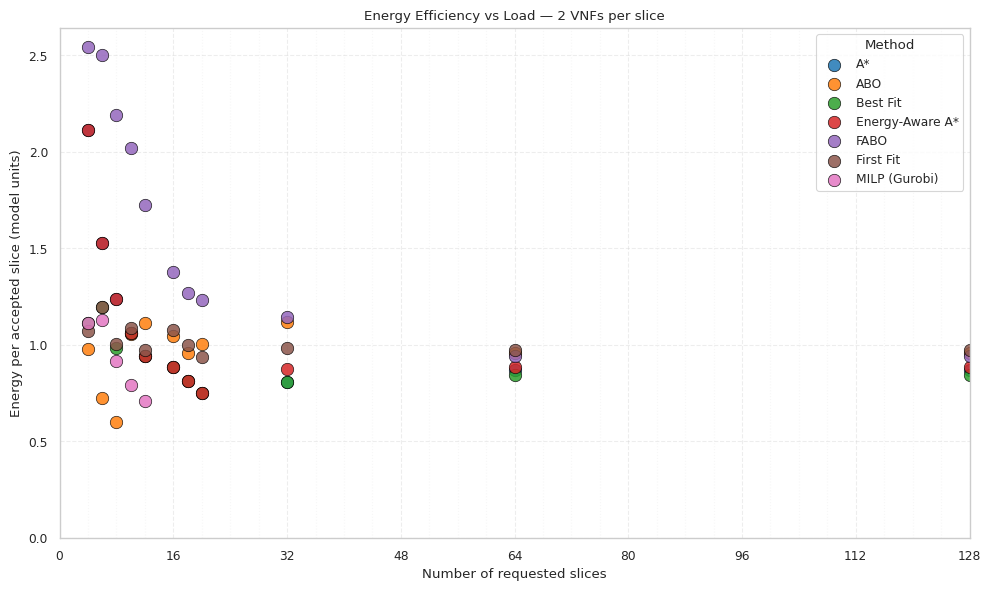

[INFO] Saved: results/2025-11-17_10-38-38/energy_vs_accepted_vnf2.png
[INFO] Saved: results/2025-11-17_10-38-38/energy_vs_accepted_vnf2.pdf


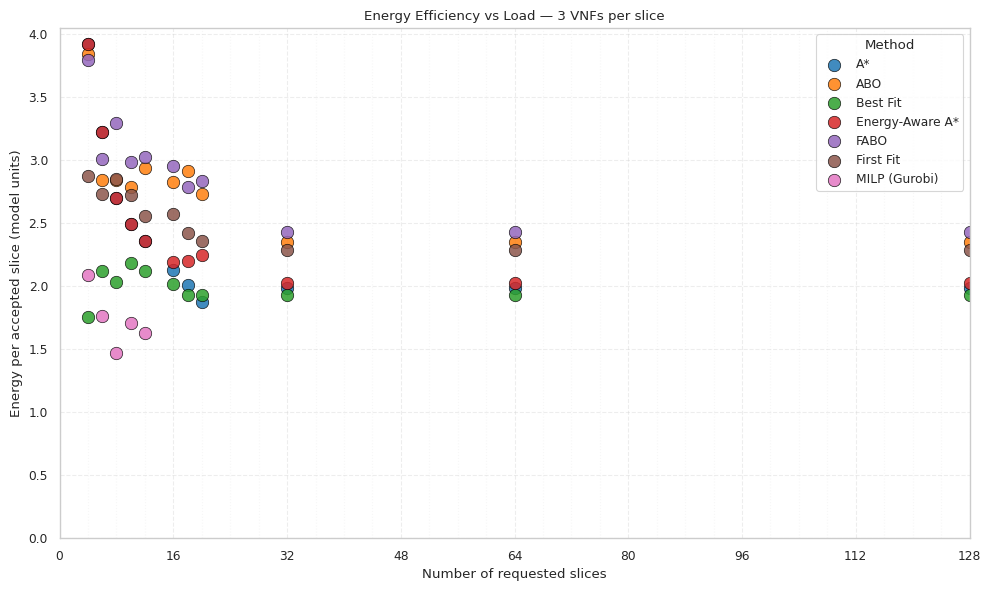

[INFO] Saved: results/2025-11-17_10-38-38/energy_vs_accepted_vnf3.png
[INFO] Saved: results/2025-11-17_10-38-38/energy_vs_accepted_vnf3.pdf


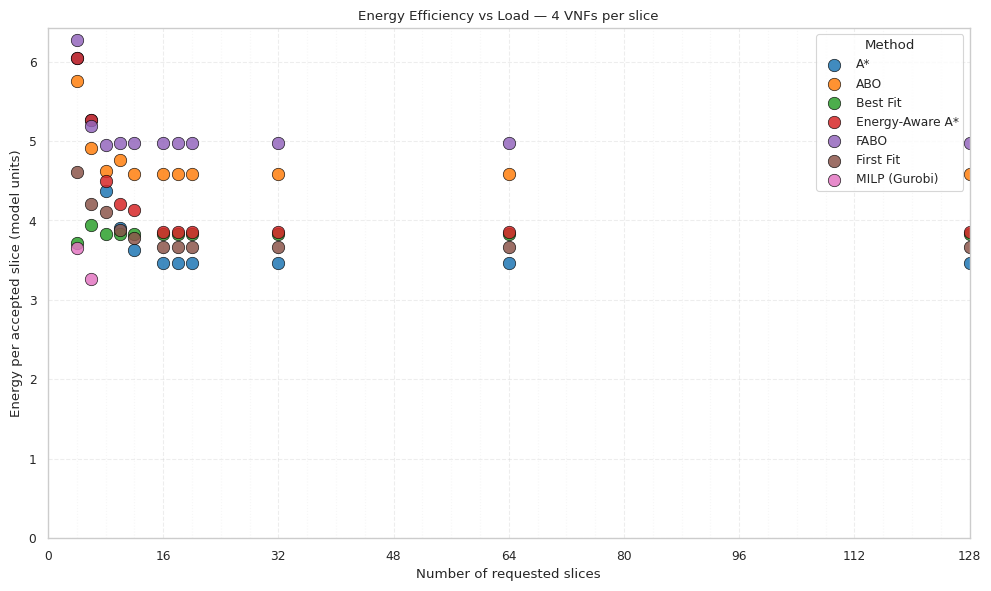

[INFO] Saved: results/2025-11-17_10-38-38/energy_vs_accepted_vnf4.png
[INFO] Saved: results/2025-11-17_10-38-38/energy_vs_accepted_vnf4.pdf


In [50]:
# --- Scatter plots: one figure per num_vnfs_per_slice (2 and 3), saved to results_dir ---
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Configure your output directory here
results_dir = globals().get("results_dir", "./results")
os.makedirs(results_dir, exist_ok=True)

df = df.copy()

# Safe division (preserve rows with accepted == 0; y will be NaN)
df["energy_per_accepted"] = np.where(
    df["accepted"] > 0,
    df["total_energy"] / df["accepted"],
    np.nan
)

# Unique VNF-per-slice values
vnf_values = sorted(df["num_vnfs_per_slice"].dropna().unique())

# Consistent color cycle across plots
color_cycle = plt.cm.tab10.colors

for vnf in vnf_values:
    d = df[df["num_vnfs_per_slice"] == vnf].copy()
    if d.empty:
        continue

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each method separately for better legend
    methods = sorted(d["method"].dropna().unique())
    for i, m in enumerate(methods):
        sub = d[d["method"] == m]
        ax.scatter(
            sub["num_slices"],            # X = scenario load
            sub["energy_per_accepted"],   # Y value
            s=80, alpha=0.85,
            edgecolors="black", linewidths=0.5,
            color=color_cycle[i % len(color_cycle)],
            label=m
        )

    # --- X axis: integer domain, but only some labels ---
    x_min = 0
    x_max = int(np.nanmax(d["num_slices"])) if len(d["num_slices"]) else 0
    ax.set_xlim(left=x_min, right=x_max)
    ax.margins(x=0.07)   # nice spacing

    span = max(1, x_max - x_min)
    if   span <= 32:
        major_step = 4
    elif span <= 64:
        major_step = 8
    else:
        major_step = 16

    ax.xaxis.set_major_locator(MultipleLocator(major_step))
    ax.xaxis.set_minor_locator(MultipleLocator(4))

    # --- Y axis: start at zero ---
    ax.set_ylim(bottom=0)

    # Labels and title
    ax.set_xlabel("Number of requested slices")
    ax.set_ylabel("Energy per accepted slice (model units)")
    ax.set_title(f"Energy Efficiency vs Load — {vnf} VNFs per slice")

    # Grid: stronger for major, lighter for minor
    ax.grid(True, which="major", linestyle="--", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":",  alpha=0.15)

    # Legend
    ax.legend(title="Method", frameon=True)

    fig.tight_layout()

    # Save figures
    base = f"energy_vs_accepted_vnf{vnf}"
    png_path = os.path.join(results_dir, f"{base}.png")
    pdf_path = os.path.join(results_dir, f"{base}.pdf")
    fig.savefig(png_path, dpi=300)
    fig.savefig(pdf_path)
    plt.show()

    print(f"[INFO] Saved: {png_path}")
    print(f"[INFO] Saved: {pdf_path}")


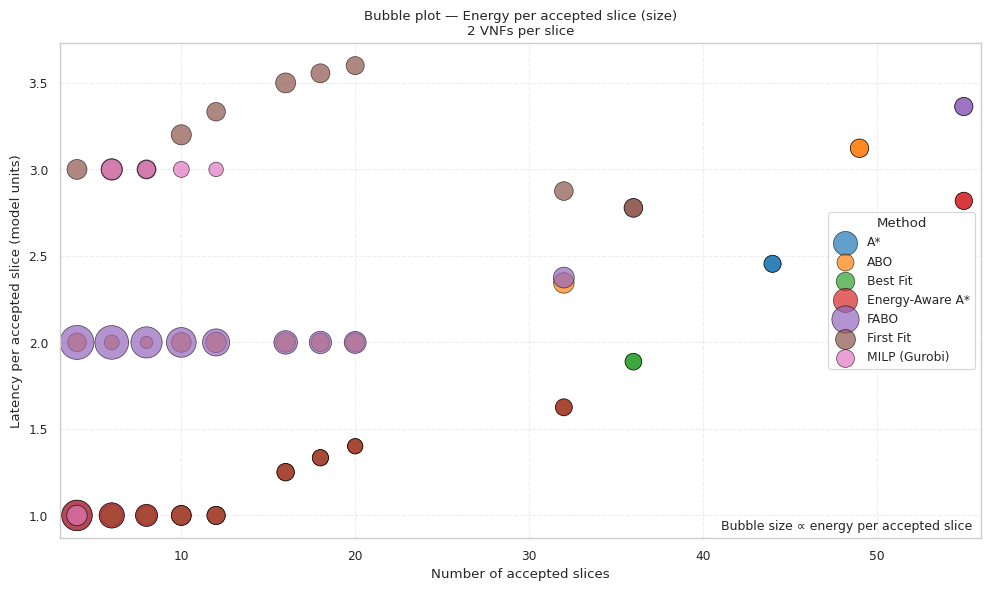

[INFO] Saved: results/2025-11-17_10-38-38/bubble_energy_latency_accepted_vnf2.png
[INFO] Saved: results/2025-11-17_10-38-38/bubble_energy_latency_accepted_vnf2.pdf


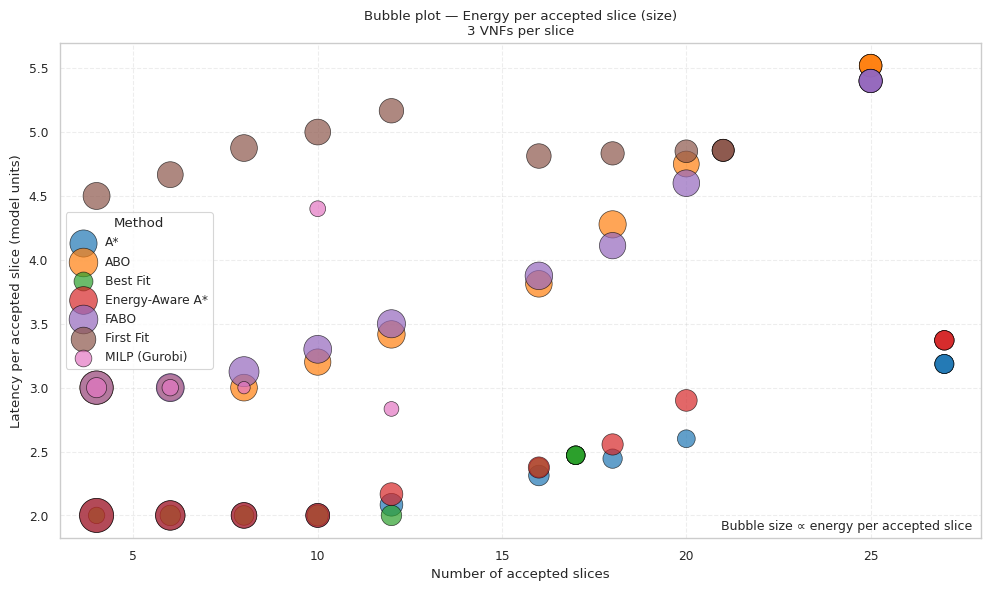

[INFO] Saved: results/2025-11-17_10-38-38/bubble_energy_latency_accepted_vnf3.png
[INFO] Saved: results/2025-11-17_10-38-38/bubble_energy_latency_accepted_vnf3.pdf


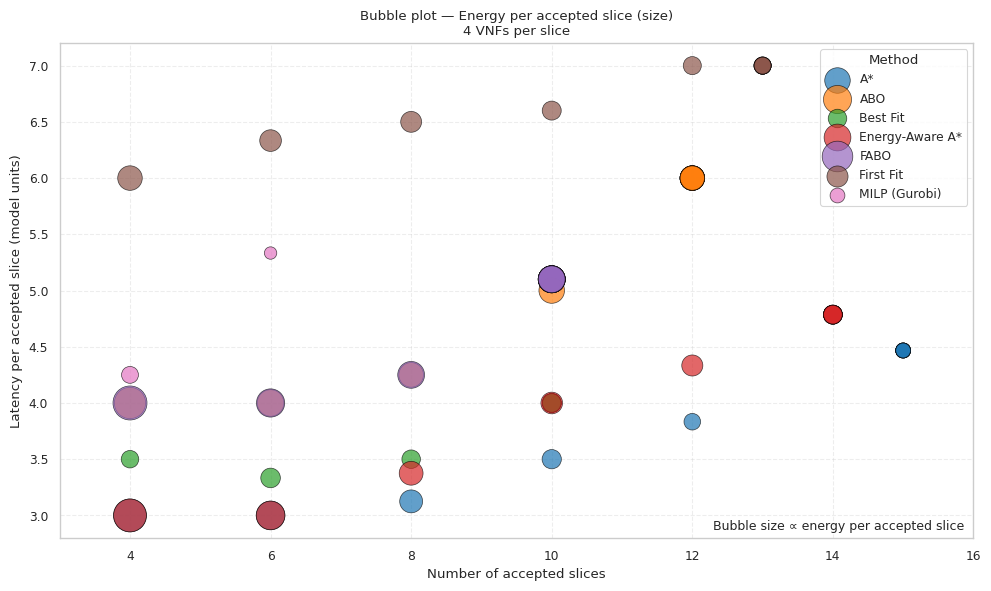

[INFO] Saved: results/2025-11-17_10-38-38/bubble_energy_latency_accepted_vnf4.png
[INFO] Saved: results/2025-11-17_10-38-38/bubble_energy_latency_accepted_vnf4.pdf


In [53]:
# Bubble plots: energy (bubble size) vs latency and acceptance
import os
import numpy as np
import matplotlib.pyplot as plt

# Ensure results_dir exists
results_dir = globals().get("results_dir", "./results")
os.makedirs(results_dir, exist_ok=True)

df_bubble = df.copy()

# Derived metrics
df_bubble["energy_per_accepted"] = np.where(
    df_bubble["accepted"] > 0,
    df_bubble["total_energy"] / df_bubble["accepted"],
    np.nan
)
df_bubble["latency_per_accepted"] = np.where(
    df_bubble["accepted"] > 0,
    df_bubble["total_latency"] / df_bubble["accepted"],
    np.nan
)

# Keep only rows where the metrics make sense
df_bubble = df_bubble[
    (df_bubble["accepted"] > 0)
    & df_bubble["energy_per_accepted"].notna()
    & df_bubble["latency_per_accepted"].notna()
].copy()

vnf_values = sorted(df_bubble["num_vnfs_per_slice"].dropna().unique())
methods = sorted(df_bubble["method"].dropna().unique())
color_cycle = plt.cm.tab10.colors
method_to_color = {m: color_cycle[i % len(color_cycle)] for i, m in enumerate(methods)}

for vnf in vnf_values:
    d = df_bubble[df_bubble["num_vnfs_per_slice"] == vnf].copy()
    if d.empty:
        continue

    # Normalize bubble sizes based on energy_per_accepted
    e = d["energy_per_accepted"].values
    e_min, e_max = np.nanmin(e), np.nanmax(e)
    if e_max == e_min:
        norm = np.ones_like(e)
    else:
        norm = (e - e_min) / (e_max - e_min)

    # Map normalized energy to marker sizes (in points^2)
    # small_bubble..big_bubble is a visual choice
    small_bubble = 80
    big_bubble = 600
    d["bubble_size"] = small_bubble + (big_bubble - small_bubble) * norm

    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter per method (color) with bubble size = energy per accepted slice
    for m in methods:
        sub = d[d["method"] == m]
        if sub.empty:
            continue
        ax.scatter(
            sub["accepted"],                 # X: how many slices were accepted
            sub["latency_per_accepted"],    # Y: latency per accepted slice
            s=sub["bubble_size"],           # Bubble size: energy per accepted slice
            color=method_to_color[m],
            alpha=0.7,
            edgecolors="black",
            linewidths=0.5,
            label=m
        )

    # Axes formatting
    x_vals = sorted(d["accepted"].unique())
    x_min, x_max = int(min(x_vals)), int(max(x_vals))
    ax.set_xlim(left=max(0, x_min - 1), right=x_max + 1)
    ax.margins(x=0.05)

    ax.set_xlabel("Number of accepted slices")
    ax.set_ylabel("Latency per accepted slice (model units)")
    ax.set_title(f"Bubble plot — Energy per accepted slice (size)\n{vnf} VNFs per slice")

    # Grid and legend
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.legend(title="Method", frameon=True)

    # Optional note about bubble sizes
    ax.text(
        0.99, 0.01,
        "Bubble size ∝ energy per accepted slice",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9
    )

    plt.tight_layout()

    # Save figure
    base = f"bubble_energy_latency_accepted_vnf{vnf}"
    png_path = os.path.join(results_dir, f"{base}.png")
    pdf_path = os.path.join(results_dir, f"{base}.pdf")
    fig.savefig(png_path, dpi=300)
    fig.savefig(pdf_path)
    plt.show()

    print(f"[INFO] Saved: {png_path}")
    print(f"[INFO] Saved: {pdf_path}")


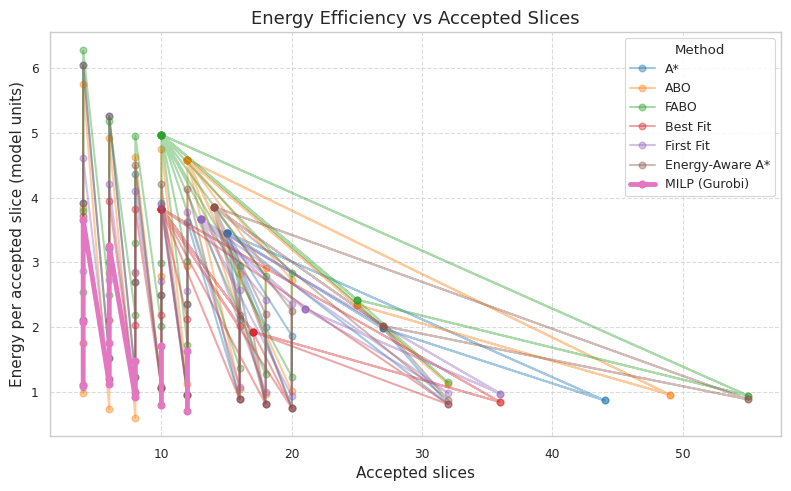

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações visuais
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

highlight = "MILP (Gurobi)"  # método que será destacado

# Paleta de cores consistente
palette = sns.color_palette("tab10", n_colors=len(df["method"].unique()))

for m, color in zip(df["method"].unique(), palette):
    subset = df[df["method"] == m]
    lw = 3.5 if m == highlight else 1.5     # destaque no MILP
    alpha = 1.0 if m == highlight else 0.4  # suaviza os outros
    zorder = 3 if m == highlight else 2
    plt.plot(
        subset["accepted"], subset["energy_per_accepted"],
        label=m, lw=lw, alpha=alpha, color=color, marker="o", zorder=zorder
    )

# Eixos e títulos
plt.xlabel("Accepted slices", fontsize=11)
plt.ylabel("Energy per accepted slice (model units)", fontsize=11)
plt.title("Energy Efficiency vs Accepted Slices", fontsize=13)
plt.legend(title="Method", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Exportar em alta resolução (opcional)
# plt.savefig("energy_efficiency_vs_accepted_slices.png", dpi=300, bbox_inches="tight")

plt.show()


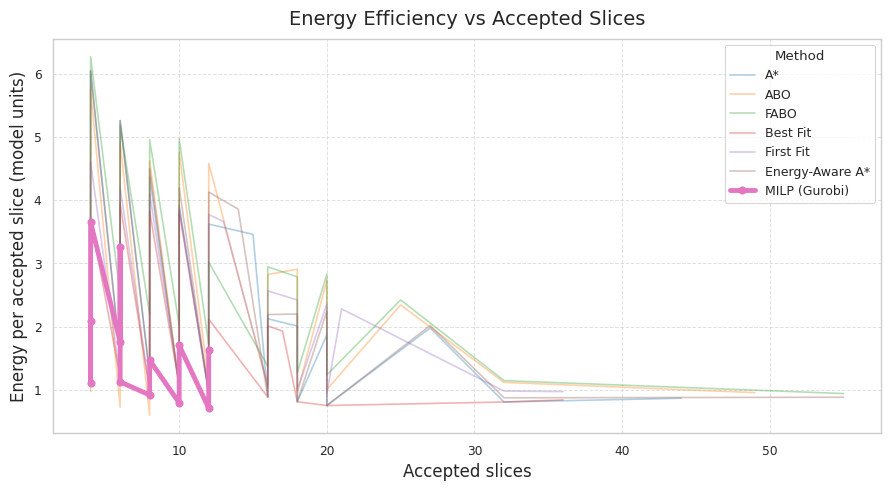

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(9,5))

highlight = "MILP (Gurobi)"  # método destacado

# Paleta consistente
palette = sns.color_palette("tab10", n_colors=len(df["method"].unique()))

for m, color in zip(df["method"].unique(), palette):
    subset = df[df["method"] == m].sort_values("accepted")
    lw = 3.5 if m == highlight else 1.2
    alpha = 1.0 if m == highlight else 0.35
    zorder = 3 if m == highlight else 2
    marker = "o" if m == highlight else None
    plt.plot(
        subset["accepted"], subset["energy_per_accepted"],
        label=m, lw=lw, alpha=alpha, color=color, marker=marker, zorder=zorder
    )

# --- Ajustes visuais ---
plt.xlabel("Accepted slices", fontsize=12)
plt.ylabel("Energy per accepted slice (model units)", fontsize=12)
plt.title("Energy Efficiency vs Accepted Slices", fontsize=14, pad=10)

# Destaque leve no eixo Y
plt.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
plt.legend(title="Method", fontsize=9, loc="upper right")
plt.tight_layout()

# Salvar em alta resolução (opcional)
# plt.savefig("energy_efficiency_vs_accepted_slices_highlighted.png", dpi=300, bbox_inches="tight")

plt.show()


In [152]:
summary = (
    df.groupby("method")[["accepted", "total_energy", "total_latency", "runtime_sec"]]
      .mean()
      .sort_values("total_energy")
)
print(summary)


                  accepted  total_energy  total_latency  runtime_sec
method                                                              
MILP (Gurobi)     2.727273      4.132273       8.878788     1.224016
First Fit        14.333333     31.131288      66.181818     0.027495
A*               15.727273     32.051780      42.121212     0.354174
Energy-Aware A*  16.212121     33.896439      46.121212     1.072993
ABO              15.303030     36.021818      59.727273    20.760913
Best Fit         13.030303     37.352727      59.575758     0.023453
FABO             15.242424     37.816477      56.939394    19.932705


In [ ]:
comp = (
    df
    .groupby(["num_slices", "method"])
    .agg(
        avg_energy=("total_energy", "mean"),
        avg_latency=("total_latency", "mean"),
        avg_accept=("accepted", "mean"),
        avg_runtime=("runtime_sec", "mean")
    )
    .reset_index()
)

print(comp)


    num_slices           method  avg_energy  avg_latency  avg_accept  \
0            4               A*   12.063750          6.0         4.0   
1            4              ABO    9.627500         10.0         4.0   
2            4         Best Fit   10.780000         17.0         4.0   
3            4  Energy-Aware A*   13.252500         11.5         4.0   
4            4             FABO   12.667500         10.0         4.0   
5            4        First Fit    7.885000         15.0         4.0   
6            6               A*   14.236250          9.0         6.0   
7            6              ABO   10.691250         15.0         6.0   
8            6         Best Fit   17.815000         24.0         6.0   
9            6  Energy-Aware A*   15.641250         17.5         6.0   
10           6             FABO   16.512500         15.0         6.0   
11           6        First Fit   11.772500         23.0         6.0   
12           8               A*   15.743125         12.0        

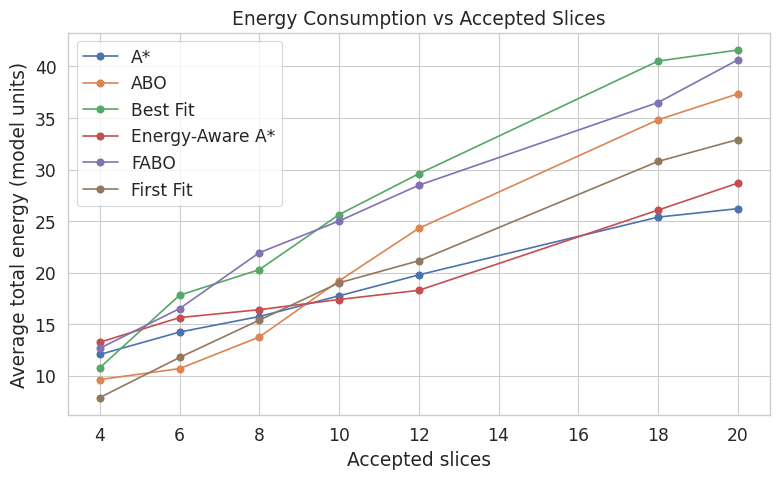

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for m in comp["method"].unique():
    subset = comp[comp["method"] == m]
    plt.plot(
        subset["avg_accept"], subset["avg_energy"],   # eixo x agora = avg_accept
        marker="o", label=m
    )

plt.xlabel("Accepted slices")
plt.ylabel("Average total energy (model units)")
plt.title("Energy Consumption vs Accepted Slices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(comp.columns.tolist())


['num_slices', 'method', 'avg_energy', 'avg_latency', 'avg_accept', 'avg_runtime']
